In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

%matplotlib inline

import os
import re
import json
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

## Read dataset

In [42]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')

In [79]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (8 <= mhci['length']) &
            (mhci['length'] <= 11) &
            (~mhci['affinity_binding'].isin(dirty_values))]

## Initialize MHCI peptide energy predictor

In [116]:
def build_helm_string(polymers, connections):
    sequences_str = '|'.join(['%s{%s}' % (p, '.'.join(s)) for p, s in polymers.items()])
    if len(connections) > 0:
        connections_str = '|'.join(['%s,%s,%d:%s-%d:%s' % (c[0], c[1], c[2], c[3], c[4], c[5]) for c in connections])
    else:
        connections_str = ''
    helm_string = '%s$%s$$$V2.0' % (sequences_str, connections_str)
    
    return helm_string


def read_pssm_file(pssm_file):
    data = []
    AA = []

    with open(pssm_file) as f:
        lines = f.readlines()
        
        n_columns = int(lines[0].split('\t')[1])

        for line in lines[1:-1]:
            sline = line.strip().split('\t')
            AA.append(sline[0])
            data.append([float(v) for v in sline[1:]])

    columns = list(range(1, n_columns + 1))
    pssm = pd.DataFrame(data=data, columns=columns, index=AA)
    
    return pssm


class MHCIPeptideScorer:
    
    def __init__(self, pssm_files, mhci_dataset, energy_cutoff=-5.0):
        self._pssm = {}
        self._reg = {}
        self._energy_cutoff = energy_cutoff
        
        # Read PSS matrices
        for pssm_file in pssm_files:
            pssm = read_pssm_file(pssm_file)
            self._pssm[len(pssm.columns)] = pssm
        
        # Score peptides using those PSSM
        pssm_scores = self.score(mhci_dataset['sequence'])
        
        # Fit PSSM score to experimental values
        for length in self._pssm.keys():
            selection_index = np.where(mhci_dataset.length == length)[0]
            
            reg = LinearRegression()
            reg.fit(pssm_scores[selection_index, None], mhci_dataset.iloc[selection_index].energy)
            
            print('----- Peptide length: %02d -----' % length)
            print('N peptide: %d' % selection_index.shape[0])
            print('R2: %.3f' % reg.score(pssm_scores[selection_index, None], mhci_dataset.iloc[selection_index].energy))
            print('RMSD : %.3f kcal/mol' % rmsd(reg.predict(pssm_scores[selection_index, None]), mhci_dataset.iloc[selection_index].energy))
            print('')
            
            self._reg[length] = reg
            
    def score(self, sequences):
        # Score peptides using those PSSM
        scores = []
                                 
        for sequence in sequences:
            score = 0
            
            try:
                pssm = self._pssm[len(sequence)]
            except:
                # We cannot score that peptide, so default score is 999
                score = 999
                scores.append(score)
                continue
                
            for i, aa in enumerate(sequence):
                score += pssm.loc[aa][i + 1]

            scores.append(score)

        scores = np.array(scores)
    
        return scores
            
    def predict_energy(self, sequences):
        scores = []
        
        pssm_scores = self.score(sequences)
        
        for sequence, pssm_score in zip(sequences, pssm_scores):
            try:
                reg = self._reg[len(sequence)]
            except:
                # We cannot score that peptide, so default energy is 0
                score = 0
                scores.append(score)
                continue
            
            score = reg.predict(np.array([pssm_score])[:, None])[0]
            scores.append(score)
        
        scores = np.array(scores)
        
        # Apply cutoff condition
        scores[scores > self._energy_cutoff] = 0.

        return scores
    
    def generate_random_peptides(self, n_peptides, energy_bounds, peptide_lengths):
        random_peptides = []
        random_peptide_scores = []

        while True:
            peptide_length = np.random.choice(peptide_lengths)
            
            p = ''.join(np.random.choice(pssm.index, peptide_length))
            s = self.predict_energy([p])[0]

            if energy_bounds[0] <= s <= energy_bounds[1]:
                helm_string = build_helm_string({'PEPTIDE1': p}, [])

                random_peptides.append(helm_string)
                random_peptide_scores.append(s)
                #print(len(random_peptides))

            if len(random_peptides) == n_peptides:
                break
        
        sorted_index = np.argsort(random_peptide_scores)
        random_peptides = np.array(random_peptides)[sorted_index]
        random_peptide_scores = np.array(random_peptide_scores)[sorted_index]

        return random_peptides, random_peptide_scores

In [113]:
pssm_files = ['../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-8.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-10.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-11.txt']
mps = MHCIPeptideScorer(pssm_files, mhci)

----- Peptide length: 08 -----
N peptide: 144
R2: 0.812
RMSD : 0.616 kcal/mol

----- Peptide length: 09 -----
N peptide: 5823
R2: 0.644
RMSD : 1.189 kcal/mol

----- Peptide length: 10 -----
N peptide: 2402
R2: 0.624
RMSD : 1.035 kcal/mol

----- Peptide length: 11 -----
N peptide: 102
R2: 0.849
RMSD : 0.601 kcal/mol



In [115]:
n_peptides = 150
peptide_length = [8, 9, 10, 11]
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(n_peptides, energy_bounds, peptide_length)

print(random_peptides)
print(random_peptide_scores)

['PEPTIDE1{E.C.G.K.L.Q.A.C}$$$$V2.0'
 'PEPTIDE1{E.C.W.E.C.C.T.W.W.W.L}$$$$V2.0'
 'PEPTIDE1{A.M.R.D.G.D.G.L.Y.H}$$$$V2.0'
 'PEPTIDE1{G.M.M.P.R.D.R.H.V.N.Y}$$$$V2.0'
 'PEPTIDE1{Y.M.D.F.T.C.I.Q.R.K}$$$$V2.0'
 'PEPTIDE1{W.H.F.A.N.C.V.A.F.I.K}$$$$V2.0'
 'PEPTIDE1{Y.V.F.Y.Y.E.F.T.Q}$$$$V2.0'
 'PEPTIDE1{P.N.I.Q.G.P.H.K.Q.A.Y}$$$$V2.0'
 'PEPTIDE1{K.S.F.S.F.S.F.E.A.N}$$$$V2.0'
 'PEPTIDE1{M.V.D.N.H.R.D.W.I}$$$$V2.0'
 'PEPTIDE1{K.N.Q.C.E.I.Y.G.V}$$$$V2.0'
 'PEPTIDE1{A.I.F.F.E.L.G.W.K.W}$$$$V2.0'
 'PEPTIDE1{G.Y.F.H.H.I.F.Y}$$$$V2.0' 'PEPTIDE1{L.M.Q.N.R.L.C.E}$$$$V2.0'
 'PEPTIDE1{M.L.Q.I.P.L.V.S.P}$$$$V2.0'
 'PEPTIDE1{R.S.M.W.R.Q.E.W.A.S}$$$$V2.0'
 'PEPTIDE1{M.Q.S.T.E.C.P.A.V.G}$$$$V2.0'
 'PEPTIDE1{D.W.I.Q.T.M.V.R.K.Q.A}$$$$V2.0'
 'PEPTIDE1{I.S.H.I.T.V.F.N.N.Q.M}$$$$V2.0'
 'PEPTIDE1{Y.A.Y.K.H.N.H.H.Q.L}$$$$V2.0'
 'PEPTIDE1{Q.Q.M.V.H.R.Y.Q.D.N.S}$$$$V2.0'
 'PEPTIDE1{C.Y.P.Y.L.C.H.S.G.P.L}$$$$V2.0'
 'PEPTIDE1{M.A.W.V.Y.H.D.N.Y.E}$$$$V2.0'
 'PEPTIDE1{V.N.M.A.T.S.W.E.H.A}$$$$V2.0'
 'PEPTIDE1{E.I.C.F.V.

## Bayesian optimization

In [7]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [8]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [9]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [11]:
def map4_fingerprint(molecule_strings, input_type='fasta', dimensions=4096, radius=2, is_counted=False, is_folded=True):
    f = {'fasta': Chem.rdmolfiles.MolFromFASTA,
         'smiles': Chem.rdmolfiles.MolFromSmiles,
         'helm': Chem.rdmolfiles.MolFromHELM}
    
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([f[input_type](s) for s in molecule_strings])
    return torch.from_numpy(np.array(fps)).float()

In [12]:
class AcqScoring:
    def __init__(self, model, acq_fun, y_exp, sequence_type='fasta'):
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        self._sequence_type = sequence_type
        
    def evaluate(self, sequences):
        fps = map4_fingerprint(sequences, self._sequence_type)
        return self._acq_fun(self._model, self._y_exp, fps)

### Generate random peptides

In [30]:
n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

# Generate random peptides
random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg, energy_bounds, energy_cutoff)

print(random_peptides)
print(random_peptide_scores)

['CRYDDEWPN' 'TSWAFVPFH' 'TALYGQNEP' 'RFGMGIDPY' 'PWNSIAMAI' 'SFECDFAQI'
 'EVADPYHHT' 'INIFWHDGM' 'PMAMHNIIW' 'NAGRHPWYS' 'AVEPSQMYE' 'WEMMKTTPW'
 'KMHYQTWYQ' 'VQETYYNNS' 'FIQSIQCPH' 'WHEHRFLQA' 'MYMREFWGC' 'CYIAINQGW'
 'WKKNYYTQA' 'GIYQPFTLF' 'HWIVWAEMK' 'KHQWASHLS' 'GMEETPPSC' 'VWLQVWSCN'
 'SFKHLCHNV' 'HQRQHDDQT' 'KYLKHHVRM' 'WTDIFVTEC' 'EIWPEMSMF' 'HRWQWVMYT'
 'VQFHDAFQQ' 'WWGFLCFNH' 'SSTAQVYSN' 'TMPRGNCEM' 'WYVNHASMF' 'WFPDWDINT'
 'RQNNDGGSV' 'NFSKHQHVC' 'SMFRSLGMP' 'KCSIGKEPI' 'VHSAFCAVW' 'YKNQQRHSC'
 'YFVAMDRMR' 'PLIACITYD' 'ATDVERVSP' 'HPMKLKIIT' 'IVGNKNDSM' 'NFLVFFDLN'
 'LAIGFTCIF' 'FIHEKTFIE' 'RQQFQVKQA' 'RLRFMTEDM' 'AKCLNAPLC' 'HWCACHWMM'
 'HLTCSRYQC' 'CYIYVNPNN' 'FQPFYADWD' 'WQKHHNQAP' 'NVHHSNFLD' 'KKTCVSCYL'
 'WGVRRTGMI' 'FWSGWNAEG' 'TLPIEPAQP' 'VSDALDQPM' 'WTSKIQQGV' 'ARQDHPSYG'
 'NMLYWMYMQ' 'TILKENCIG' 'QAAKCNFGR' 'LQVTDRMKI' 'EYWWISKYV' 'MDPIVESMA'
 'GEDTVQYNS' 'HADAVRTPW' 'VIWDPVTRP' 'RWWFKEMHF' 'THITDYWYC' 'IDQPKMVLF'
 'PQYAVKEEV' 'HLFMPQAIS' 'TGSKTKHQI' 'LTNMTSRDV' 'V

### Candidate peptides sampling with PBIL

In [22]:
class PBIL(object):
    def __init__(self, scorer, peptide_length=9, population_size=96, n_best=48,
                 learning_rate=0.5, mut_prob=0.0, mut_shift=0.00, greater_is_better=True, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        
        # Scoring object
        self._scorer = scorer
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._greater_is_better = greater_is_better
        self._best_score = np.inf * (-1) ** (self._greater_is_better)

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        return self._scorer.evaluate([''.join(individual)])[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])
        
        if self._greater_is_better:
            sorted_peptide_indices = np.argsort(np.ravel(scores))[::-1]
        else:
            sorted_peptide_indices = np.argsort(np.ravel(scores))
        
        best_peptide_indices = sorted_peptide_indices[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
            
            for amino_acid in amino_acids:
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])
            
            
def find_next_candidates(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96

    #Initialize the PBIL EDA
    pbil = PBIL(scorer, peptide_length=NLEN, population_size=NIND, n_best=NBEST,
                greater_is_better=greater_is_better)

    scaling_factor = (-1) ** (not greater_is_better)
    creator.create("Fitness", base.Fitness, weights=(scaling_factor,))
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NCAN)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)
    
    candidates = [''.join(s) for s in hof.items]
    candidates_acq = np.array([k.values[0] for k in hof.keys])

    return candidates, candidates_acq

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1
gen	nevals	avg       	std     	min      	max        
0  	250   	-0.0259962	0.019745	-0.160736	-0.00134414
1  	250   	-0.0376788	0.02787 	-0.204167	-0.00307993
2  	250   	-0.0480689	0.0285624	-0.197519	-0.00902506
3  	250   	-0.0545181	0.0291919	-0.162086	-0.00722167
4  	250   	-0.0630522	0.030576 	-0.170649	-0.0109588 
5  	250   	-0.0715884	0.0332365	-0.240571	-0.0119456 
6  	250   	-0.0744309	0.0359599	-0.272698	-0.0140704 
7  	250   	-0.0804542	0.0361362	-0.229891	-0.0110081 
8  	250   	-0.0835514	0.0360544	-0.235184	-0.0197127 
9  	250   	-0.093101 	0.0408384	-0.228537	-0.0257803 

N pep:  246
Best peptide: -11.087
N pep under -12

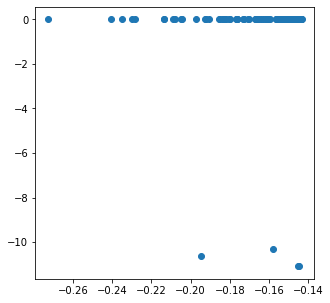




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max         
0  	250   	-0.0085536	0.0128605	-0.0882406	-1.46071e-06
1  	250   	-0.0170213	0.0204892	-0.104308 	-1.17377e-05
2  	250   	-0.0259671	0.0283712	-0.183733 	-0.000133996
3  	250   	-0.0320361	0.0271681	-0.171693 	-0.000954252
4  	250   	-0.0395702	0.0364189	-0.225307 	-0.000375154
5  	250   	-0.0515446	0.0387513	-0.19966  	-0.00276733 
6  	250   	-0.063161 	0.044383 	-0.229198 	-0.00476776 
7  	250   	-0.0687476	0.046452 	-0.301102 	-0.00339322 
8  	250   	-0.0738614	0.0522369	-0.323193 	-0.00140846 
9  	250   	-0.0785394	0.050955 	-0.327862 	-0.00134274 

N pep:  342
Best peptide: -11.087
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 158
N pep under -5 kcal/mol: 161
Non binding pep        : 181


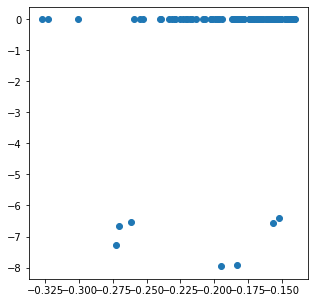




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00509328	0.0109685	-0.124317	-4.93324e-06
1  	250   	-0.00921749	0.0155509	-0.145298	-9.87325e-06
2  	250   	-0.0123637 	0.0200488	-0.170657	-2.26298e-05
3  	250   	-0.0174222 	0.0240364	-0.174909	-9.61754e-05
4  	250   	-0.0245109 	0.0312136	-0.176233	-3.04719e-05
5  	250   	-0.0270017 	0.0384701	-0.299966	-0.000506583
6  	250   	-0.0312761 	0.0359   	-0.200613	-0.000118684
7  	250   	-0.0430987 	0.0471415	-0.290189	-0.000240774
8  	250   	-0.0466106 	0.0525953	-0.310955	-0.00017094 
9  	250   	-0.0568977 	0.0540338	-0.27477 	-0.000258087

N pep:  438
Best peptide: -11.087
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 014
N pep under -8 kcal/mol: 044
N pep under -7 kcal/mol: 168
N pep under -6 kcal/mol: 205
N pep under -5 kcal/mol: 209
Non binding pep        : 229


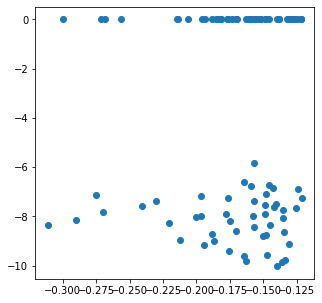




Run: 2
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std     	min      	max        
0  	250   	-0.0275021	0.021591	-0.166059	-0.00184898
1  	250   	-0.0372563	0.0243642	-0.172374	-0.00239373
2  	250   	-0.0469535	0.025343 	-0.172454	-0.00279193
3  	250   	-0.0607574	0.0293329	-0.139819	-0.0092861 
4  	250   	-0.0686567	0.0341169	-0.197901	-0.0123209 
5  	250   	-0.0765139	0.0343842	-0.185399	-0.0163072 
6  	250   	-0.0813918	0.0355579	-0.247239	-0.0200355 
7  	250   	-0.0887212	0.0366721	-0.230169	-0.0236773 
8  	250   	-0.0912645	0.035043 	-0.217962	-0.0245775 
9  	250   	-0.0901664	0.0368097	-0.238542	-0.0229437 

N pep:  246
Best peptide: -12.002
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 011
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 135
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 166
Non binding pep        : 080


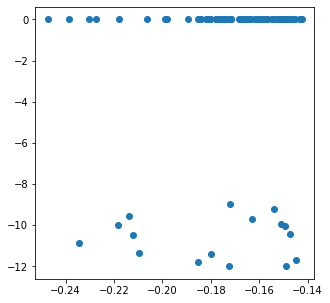




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min      	max         
0  	250   	-0.011685	0.0179113	-0.148065	-1.06645e-05
1  	250   	-0.0288115	0.0342159	-0.229385	-5.49223e-05
2  	250   	-0.0421284	0.0422736	-0.35878 	-6.29168e-05
3  	250   	-0.0531632	0.045404 	-0.252638	-0.000164921
4  	250   	-0.0614554	0.0521288	-0.373698	-0.00186227 
5  	250   	-0.072082 	0.052592 	-0.31576 	-0.00122198 
6  	250   	-0.0863561	0.0563373	-0.376992	-0.00500196 
7  	250   	-0.0922926	0.0621081	-0.330735	-0.00954531 
8  	250   	-0.103238 	0.0687269	-0.446413	-0.00356738 
9  	250   	-0.111211 	0.0676257	-0.38963 	-0.0155704  

N pep:  342
Best peptide: -12.002
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 012
N pep under -9 kcal/mol: 016
N pep under -8 kcal/mol: 034
N pep under -7 kcal/mol: 140
N pep under -6 kcal/mol: 169
N pep under -5 kcal/mol: 172
Non binding pep        : 170


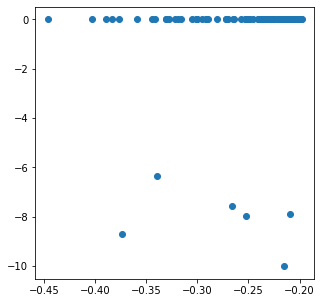




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00844696	0.0166789	-0.228633	-6.13225e-05
1  	250   	-0.0121005 	0.0186442	-0.215707	-4.83961e-05
2  	250   	-0.0219703 	0.0294584	-0.21342 	-3.86534e-06
3  	250   	-0.0255283 	0.0254412	-0.158275	-0.000300097
4  	250   	-0.0339068 	0.0329228	-0.211724	-0.000859476
5  	250   	-0.0383012 	0.0384149	-0.242375	-0.00241641 
6  	250   	-0.0386347 	0.0347809	-0.24226 	-0.00209585 
7  	250   	-0.0415644 	0.0343248	-0.226527	-0.00113219 
8  	250   	-0.0439449 	0.0376277	-0.28652 	-0.00202744 
9  	250   	-0.0477238 	0.0450035	-0.321739	-0.00225954 

N pep:  438
Best peptide: -12.002
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 013
N pep under -9 kcal/mol: 022
N pep under -8 kcal/mol: 048
N pep under -7 kcal/mol: 171
N pep under -6 kcal/mol: 206
N pep under -5 kcal/mol: 209
Non binding pep        : 229


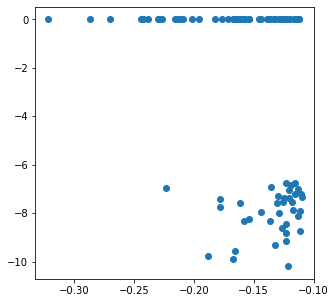




Run: 3
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0234184	0.0187876	-0.112134	-0.000674632
1  	250   	-0.0380363	0.0255573	-0.134841	-0.00118132 
2  	250   	-0.0485111	0.0286467	-0.187855	-0.00754481 
3  	250   	-0.0554587	0.0275989	-0.154448	-0.00978737 
4  	250   	-0.0651959	0.0308635	-0.21961 	-0.0114072  
5  	250   	-0.0663051	0.0300255	-0.177925	-0.0134959  
6  	250   	-0.0650424	0.0318284	-0.169316	-0.015643   
7  	250   	-0.0670311	0.0290317	-0.171789	-0.0127956  
8  	250   	-0.0789836	0.0340554	-0.203133	-0.0156022  
9  	250   	-0.081557 	0.0346279	-0.210101	-0.0163911  

N pep:  246
Best peptide: -10.452
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 154
Non binding pep        : 092


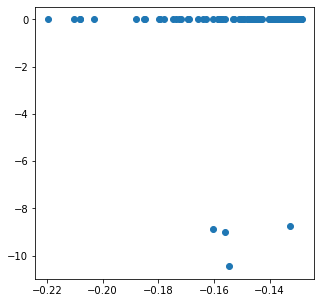




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std     	min      	max         
0  	250   	-0.0155335	0.025099	-0.168082	-1.72471e-06
1  	250   	-0.0284068	0.0339702	-0.189729	-2.10104e-06
2  	250   	-0.0462458	0.0598395	-0.607496	-0.000250995
3  	250   	-0.0685058	0.0713714	-0.672029	-0.0008215  
4  	250   	-0.0882669	0.0657958	-0.436652	-0.00185841 
5  	250   	-0.111167 	0.0754894	-0.674192	-0.000647067
6  	250   	-0.119987 	0.0797018	-0.410884	-0.00703601 
7  	250   	-0.133462 	0.079996 	-0.407796	-0.0111472  
8  	250   	-0.137248 	0.0837841	-0.441615	-0.00976721 
9  	250   	-0.165343 	0.0985675	-0.670672	-0.0168403  

N pep:  342
Best peptide: -10.452
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 164
N pep under -5 kcal/mol: 167
Non binding pep        : 175


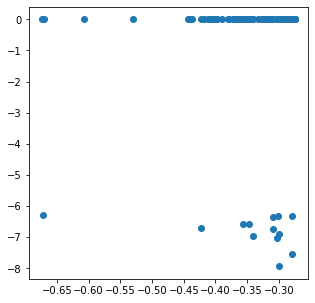




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00689583	0.0116385	-0.102447	-2.09021e-05
1  	250   	-0.0164708 	0.030873 	-0.33824 	-3.65746e-05
2  	250   	-0.0245221 	0.0290526	-0.228762	-0.000140728
3  	250   	-0.0325154 	0.0376155	-0.34572 	-0.00014851 
4  	250   	-0.0389525 	0.0386524	-0.208061	-0.000170033
5  	250   	-0.047563  	0.0452893	-0.283328	-0.000167662
6  	250   	-0.0545812 	0.0537288	-0.271452	-0.000832747
7  	250   	-0.0557796 	0.0487796	-0.30052 	-0.000855961
8  	250   	-0.0557052 	0.0496211	-0.343245	-0.000583334
9  	250   	-0.0614469 	0.0604832	-0.324646	-0.000684979

N pep:  438
Best peptide: -10.452
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 035
N pep under -7 kcal/mol: 160
N pep under -6 kcal/mol: 213
N pep under -5 kcal/mol: 217
Non binding pep        : 221


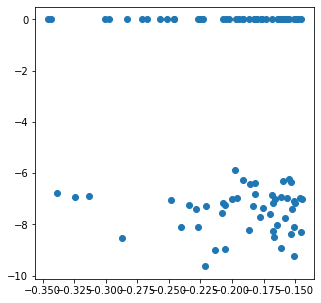




Run: 4
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max         
0  	250   	-0.0253628	0.0188676	-0.0950648	-0.000949022
1  	250   	-0.034639 	0.0228809	-0.143912 	-0.00185993 
2  	250   	-0.0414507	0.0236335	-0.150975 	-0.0068934  
3  	250   	-0.0494357	0.0277769	-0.189194 	-0.00878036 
4  	250   	-0.057726 	0.0319959	-0.216325 	-0.00886057 
5  	250   	-0.0674436	0.032686 	-0.230367 	-0.0147422  
6  	250   	-0.072696 	0.0341616	-0.21877  	-0.0162134  
7  	250   	-0.0738892	0.0344888	-0.240609 	-0.0137673  
8  	250   	-0.0786671	0.034775 	-0.205359 	-0.0158887  
9  	250   	-0.0874745	0.0356521	-0.209008 	-0.0286976  

N pep:  246
Best peptide: -11.777
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 127
N pep under -6 kcal/mol: 155
N pep under -5 kcal/mol: 158
Non binding pep        : 088


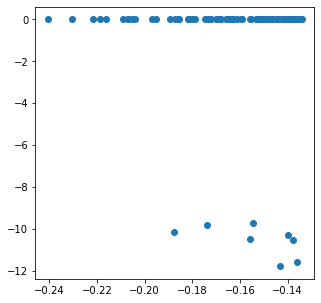




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max       
0  	250   	-0.00487545	0.00865289	-0.0719251	-3.028e-06
1  	250   	-0.0104051 	0.0127676 	-0.0752174	-3.95884e-06
2  	250   	-0.0168926 	0.0202446 	-0.179151 	-4.22624e-09
3  	250   	-0.0252266 	0.0258669 	-0.219665 	-0.000117261
4  	250   	-0.0351427 	0.0315079 	-0.195507 	-0.000266226
5  	250   	-0.0413118 	0.0328601 	-0.161727 	-0.00146299 
6  	250   	-0.0471379 	0.0319424 	-0.189895 	-0.00449639 
7  	250   	-0.0488654 	0.0343332 	-0.221101 	-0.00227349 
8  	250   	-0.0525121 	0.034356  	-0.249603 	-0.0052805  
9  	250   	-0.0532468 	0.0317161 	-0.166168 	-0.00530325 

N pep:  342
Best peptide: -11.777
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 027
N pep under -7 kcal/mol: 132
N pep under -6 kcal/mol: 164
N pep under -5 kcal/mol: 167
Non binding pep        : 175


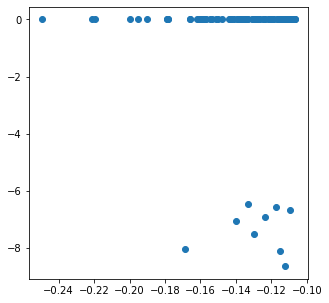




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max         
0  	250   	-0.00331457	0.0055286	-0.0431303	-8.97807e-06
1  	250   	-0.00486349	0.00767985	-0.0609133	-4.62932e-07
2  	250   	-0.00840049	0.0131929 	-0.101131 	-2.0487e-05 
3  	250   	-0.010096  	0.0126774 	-0.0910538	-8.46172e-05
4  	250   	-0.0136385 	0.0170535 	-0.143013 	-4.20937e-05
5  	250   	-0.0150233 	0.0165497 	-0.0953531	-0.000165882
6  	250   	-0.0186386 	0.0209224 	-0.149831 	-8.72917e-06
7  	250   	-0.0201603 	0.0253196 	-0.28858  	-0.000117809
8  	250   	-0.0250245 	0.026298  	-0.151178 	-0.000289087
9  	250   	-0.0278505 	0.0261231 	-0.126772 	-0.000174761

N pep:  438
Best peptide: -11.777
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 007
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 044
N pep under -7 kcal/mol: 165
N pep under -6 kcal/mol: 202
N pep under -5 kcal/mol: 205
Non binding pep        : 233


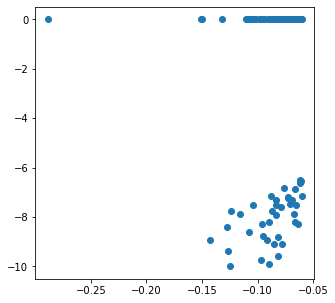




Run: 5
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0280936	0.0210126	-0.116223	-0.000253705
1  	250   	-0.0371885	0.0250533	-0.152329	-0.00337847 
2  	250   	-0.0453101	0.0271329	-0.149497	-0.00627236 
3  	250   	-0.056566 	0.0310059	-0.22936 	-0.00581826 
4  	250   	-0.0626188	0.0333593	-0.19147 	-0.0092654  
5  	250   	-0.0684358	0.0357788	-0.218891	-0.0108066  
6  	250   	-0.0727779	0.0340336	-0.209035	-0.0115276  
7  	250   	-0.0793871	0.0370062	-0.215585	-0.0167104  
8  	250   	-0.0844882	0.0375164	-0.239874	-0.0180677  
9  	250   	-0.0875235	0.0381589	-0.23871 	-0.0219438  

N pep:  246
Best peptide: -11.511
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 155
Non binding pep        : 091


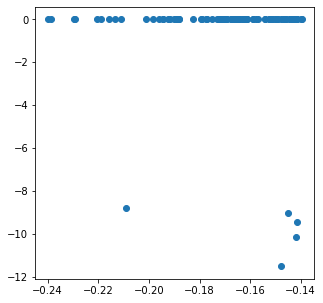




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00493447	0.00933671	-0.0808312	-1.99584e-06
1  	250   	-0.00924953	0.0150211 	-0.127111 	-1.89069e-05
2  	250   	-0.0167634 	0.0169674 	-0.0975248	-0.000135429
3  	250   	-0.0234574 	0.0232793 	-0.136548 	-0.00015236 
4  	250   	-0.0353007 	0.0299478 	-0.150732 	-0.000527366
5  	250   	-0.0432946 	0.0308264 	-0.223289 	-5.00493e-05
6  	250   	-0.0464396 	0.0293193 	-0.161548 	-0.00263127 
7  	250   	-0.0539299 	0.0350349 	-0.195797 	-0.00297595 
8  	250   	-0.0648579 	0.0382017 	-0.220946 	-0.00327998 
9  	250   	-0.0690207 	0.0345042 	-0.213845 	-0.00720402 

N pep:  342
Best peptide: -11.511
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 158
N pep under -5 kcal/mol: 162
Non binding pep        : 180


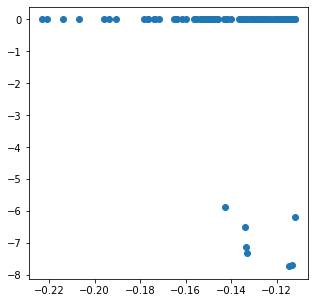




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00282757	0.00587736	-0.0665936	-4.39842e-06
1  	250   	-0.00519918	0.0102761 	-0.0758852	-1.2342e-05 
2  	250   	-0.00908076	0.0143547 	-0.0764517	-2.04244e-05
3  	250   	-0.0108914 	0.0149076 	-0.089965 	-3.98555e-06
4  	250   	-0.0119579 	0.0162165 	-0.117049 	-3.89537e-05
5  	250   	-0.0174864 	0.0210024 	-0.143431 	-7.17443e-06
6  	250   	-0.0219849 	0.0262974 	-0.174006 	-5.25097e-05
7  	250   	-0.021795  	0.0278231 	-0.27711  	-7.08914e-05
8  	250   	-0.023605  	0.0249085 	-0.122297 	-0.000142084
9  	250   	-0.0293414 	0.0346742 	-0.270977 	-0.000113984

N pep:  438
Best peptide: -11.511
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 010
N pep under -8 kcal/mol: 037
N pep under -7 kcal/mol: 160
N pep under -6 kcal/mol: 201
N pep under -5 kcal/mol: 205
Non binding pep        : 233


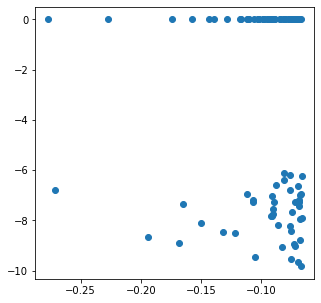




Run: 6
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max        
0  	250   	-0.0267122	0.0207868	-0.112523	-0.00076813
1  	250   	-0.0412671	0.0272582	-0.184414	-0.00257682
2  	250   	-0.0492954	0.0269031	-0.160943	-0.00244571
3  	250   	-0.0554332	0.0286713	-0.16456 	-0.0133515 
4  	250   	-0.062976 	0.0307477	-0.181947	-0.0124853 
5  	250   	-0.0762426	0.0334289	-0.20894 	-0.0180231 
6  	250   	-0.072453 	0.0306831	-0.190599	-0.0103914 
7  	250   	-0.0729251	0.031738 	-0.205552	-0.0147486 
8  	250   	-0.0848494	0.0355957	-0.208326	-0.0201033 
9  	250   	-0.0814943	0.0348004	-0.212322	-0.018111  

N pep:  246
Best peptide: -11.932
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 155
Non binding pep        : 091


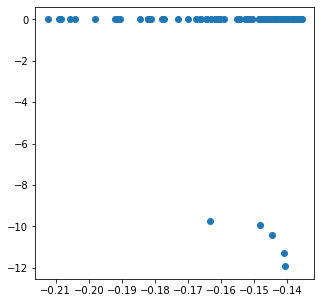




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max         
0  	250   	-0.00442944	0.0104393	-0.0903677	-2.70922e-09
1  	250   	-0.0119414 	0.0186599	-0.13146  	-2.58726e-06
2  	250   	-0.0189647 	0.0217447	-0.177604 	-3.82174e-06
3  	250   	-0.0284023 	0.0292645	-0.186098 	-0.000412995
4  	250   	-0.038703  	0.0336079	-0.290837 	-0.00193041 
5  	250   	-0.0427949 	0.0293398	-0.173662 	-0.001737   
6  	250   	-0.049812  	0.0388062	-0.28037  	-0.0035772  
7  	250   	-0.0575618 	0.039802 	-0.273317 	-0.0067447  
8  	250   	-0.0578816 	0.0400038	-0.291435 	-0.00367201 
9  	250   	-0.0630068 	0.0377466	-0.203293 	-0.00145439 

N pep:  342
Best peptide: -11.932
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 168
Non binding pep        : 174


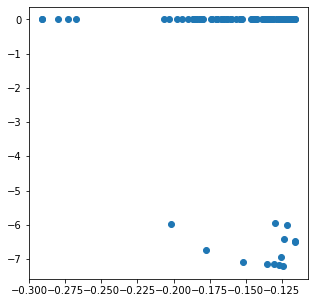




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max        
0  	250   	-0.00231316	0.00425623	-0.0319155	-5.3344e-07
1  	250   	-0.00436314	0.00763999	-0.0825498	-1.49178e-06
2  	250   	-0.00507441	0.00641298	-0.0370627	-1.99289e-05
3  	250   	-0.00749215	0.0113855 	-0.0932888	-7.82357e-06
4  	250   	-0.00801936	0.0111116 	-0.0767256	-3.95666e-05
5  	250   	-0.0083495 	0.00997586	-0.0525765	-1.21624e-05
6  	250   	-0.00978503	0.0144943 	-0.134741 	-4.45468e-06
7  	250   	-0.0117358 	0.0138552 	-0.0833472	-5.93557e-06
8  	250   	-0.0152657 	0.0213052 	-0.141251 	-8.01246e-05
9  	250   	-0.017261  	0.021583  	-0.121799 	-2.10521e-05

N pep:  438
Best peptide: -11.932
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 009
N pep under -8 kcal/mol: 035
N pep under -7 kcal/mol: 159
N pep under -6 kcal/mol: 199
N pep under -5 kcal/mol: 205
Non binding pep        : 233


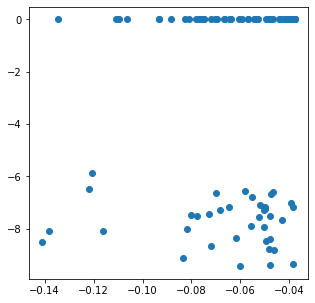




Run: 7
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max         
0  	250   	-0.0268711	0.0177218	-0.0917139	-0.000934123
1  	250   	-0.0361964	0.0289336	-0.219336 	-0.00257007 
2  	250   	-0.0449038	0.0271776	-0.156988 	-0.00592127 
3  	250   	-0.0549817	0.0297667	-0.17495  	-0.00755624 
4  	250   	-0.0638349	0.0339082	-0.214083 	-0.0139176  
5  	250   	-0.0696693	0.0313155	-0.197451 	-0.017304   
6  	250   	-0.0733933	0.0327224	-0.185071 	-0.0122375  
7  	250   	-0.0836424	0.038403 	-0.209017 	-0.0163234  
8  	250   	-0.0897248	0.0404318	-0.231356 	-0.0243315  
9  	250   	-0.0918376	0.0346679	-0.196139 	-0.0239104  

N pep:  246
Best peptide: -10.359
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 152
N pep under -5 kcal/mol: 155
Non binding pep        : 091


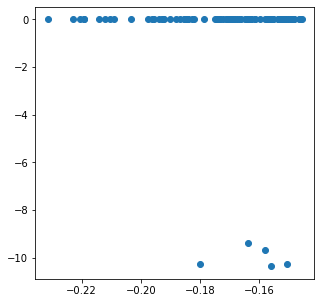




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0203799	0.0296779	-0.237194	-1.76252e-06
1  	250   	-0.0381301	0.045555 	-0.295628	-4.88714e-06
2  	250   	-0.0642328	0.0536482	-0.361369	-0.000395878
3  	250   	-0.0860784	0.0682855	-0.447319	-0.000241593
4  	250   	-0.0970927	0.0608697	-0.365555	-0.000777486
5  	250   	-0.139565 	0.0797061	-0.416138	-0.00698789 
6  	250   	-0.163053 	0.0785936	-0.482309	-0.0236305  
7  	250   	-0.173206 	0.0829773	-0.441587	-0.0233551  
8  	250   	-0.181927 	0.0894528	-0.505829	-0.028943   
9  	250   	-0.18773  	0.0810797	-0.465639	-0.0278367  

N pep:  342
Best peptide: -10.359
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 157
N pep under -5 kcal/mol: 160
Non binding pep        : 182


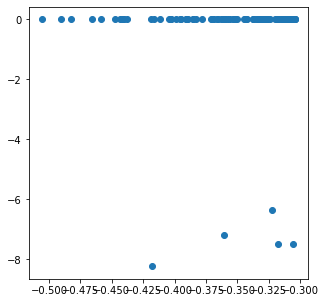




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0120387	0.0213812	-0.181795	-4.17682e-05
1  	250   	-0.0246048	0.0354461	-0.314686	-5.01999e-05
2  	250   	-0.0369195	0.0435835	-0.307407	-0.000171747
3  	250   	-0.0471316	0.0492273	-0.310948	-0.000349629
4  	250   	-0.0470252	0.0518398	-0.332904	-0.000469225
5  	250   	-0.0552475	0.0601177	-0.440931	-0.00036771 
6  	250   	-0.0695633	0.0705532	-0.42222 	-0.000450565
7  	250   	-0.0727298	0.0626744	-0.379356	-0.0002069  
8  	250   	-0.0707037	0.0684748	-0.38674 	-0.000115414
9  	250   	-0.0925483	0.0866959	-0.510106	-0.00164839 

N pep:  438
Best peptide: -10.359
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 039
N pep under -7 kcal/mol: 155
N pep under -6 kcal/mol: 192
N pep under -5 kcal/mol: 195
Non binding pep        : 243


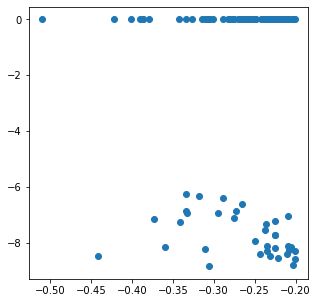




Run: 8
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max         
0  	250   	-0.0247641	0.0186658	-0.112974	-0.000486285
1  	250   	-0.0372942	0.0229469	-0.118713	-0.00179694 
2  	250   	-0.0488479	0.0305743	-0.181182	-0.00382026 
3  	250   	-0.0553638	0.0302733	-0.153023	-0.00690131 
4  	250   	-0.060491 	0.0323984	-0.221388	-0.00881483 
5  	250   	-0.0739659	0.0360855	-0.224445	-0.00868971 
6  	250   	-0.0718476	0.0338571	-0.200676	-0.0191633  
7  	250   	-0.077489 	0.0379302	-0.197789	-0.0135142  
8  	250   	-0.0844213	0.0386262	-0.24676 	-0.0208755  
9  	250   	-0.0813783	0.0351029	-0.227751	-0.0104689  

N pep:  246
Best peptide: -11.637
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 009
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 156
N pep under -5 kcal/mol: 159
Non binding pep        : 087


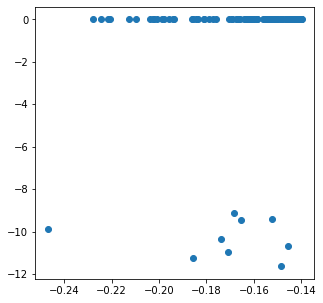




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min     	max        
0  	250   	-0.00852192	0.0156986	-0.11228	-1.7074e-06
1  	250   	-0.0206291 	0.0345279	-0.328085	-4.23023e-05
2  	250   	-0.0337323 	0.0407279	-0.304401	-2.31746e-05
3  	250   	-0.0490824 	0.0521253	-0.3075  	-3.90316e-05
4  	250   	-0.0656414 	0.0540941	-0.339363	-0.00257813 
5  	250   	-0.0673755 	0.056703 	-0.301123	-0.00327552 
6  	250   	-0.0793252 	0.0570684	-0.387217	-0.00131784 
7  	250   	-0.0832744 	0.0571587	-0.334422	-0.00234673 
8  	250   	-0.0897187 	0.0576235	-0.327622	-0.00677339 
9  	250   	-0.109597  	0.0666478	-0.359642	-0.0104158  

N pep:  342
Best peptide: -11.637
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 011
N pep under -8 kcal/mol: 027
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 166
Non binding pep        : 176


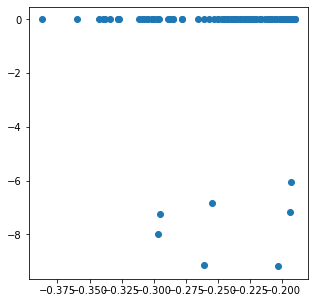




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00279035	0.00435907	-0.0296901	-4.48081e-07
1  	250   	-0.00630499	0.0105451 	-0.0699182	-1.80855e-05
2  	250   	-0.00724266	0.0105806 	-0.0929435	-4.4338e-05 
3  	250   	-0.00993942	0.0147327 	-0.133378 	-6.61054e-06
4  	250   	-0.0168857 	0.0213454 	-0.166765 	-0.000161703
5  	250   	-0.0165731 	0.0218806 	-0.163676 	-9.69159e-05
6  	250   	-0.019983  	0.0190958 	-0.121561 	-0.000184016
7  	250   	-0.02454   	0.0257898 	-0.147829 	-0.00022689 
8  	250   	-0.0287895 	0.029101  	-0.174661 	-0.000568567
9  	250   	-0.0296279 	0.0312314 	-0.289302 	-0.000146983

N pep:  438
Best peptide: -11.637
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 016
N pep under -8 kcal/mol: 049
N pep under -7 kcal/mol: 170
N pep under -6 kcal/mol: 210
N pep under -5 kcal/mol: 215
Non binding pep        : 223


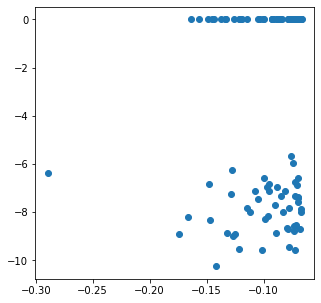




Run: 9
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min     	max         
0  	250   	-0.0254617	0.0202946	-0.11642	-0.000826027
1  	250   	-0.0366009	0.023941 	-0.134704	-0.00144158 
2  	250   	-0.0453965	0.0297112	-0.151741	-0.00659285 
3  	250   	-0.0535666	0.0298402	-0.176116	-0.00774239 
4  	250   	-0.0570199	0.029633 	-0.172551	-0.00724295 
5  	250   	-0.0630241	0.0326969	-0.205135	-0.00240091 
6  	250   	-0.0724873	0.0309397	-0.221941	-0.0145482  
7  	250   	-0.076055 	0.0344052	-0.186479	-0.0151588  
8  	250   	-0.0847852	0.0349432	-0.209805	-0.0201107  
9  	250   	-0.0822209	0.0344177	-0.210938	-0.0138504  

N pep:  246
Best peptide: -12.163
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 006
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 125
N pep under -6 kcal/mol: 153
N pep under -5 kcal/mol: 156
Non binding pep        : 090


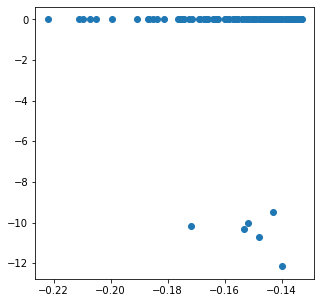




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00371388	0.00635935	-0.0541344	-1.39542e-07
1  	250   	-0.00741746	0.0102557 	-0.0870797	-1.98242e-06
2  	250   	-0.0112523 	0.0131473 	-0.0871158	-6.09758e-06
3  	250   	-0.016439  	0.016063  	-0.0884282	-1.75645e-05
4  	250   	-0.0225872 	0.0192839 	-0.129077 	-0.000211136
5  	250   	-0.027521  	0.0225024 	-0.140285 	-0.00120163 
6  	250   	-0.0311584 	0.0220737 	-0.119816 	-0.00183936 
7  	250   	-0.0341901 	0.0229262 	-0.120601 	-0.000271603
8  	250   	-0.036065  	0.0243689 	-0.153172 	-0.00152455 
9  	250   	-0.0409267 	0.0259267 	-0.16723  	-0.00575678 

N pep:  342
Best peptide: -12.163
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 130
N pep under -6 kcal/mol: 160
N pep under -5 kcal/mol: 163
Non binding pep        : 179


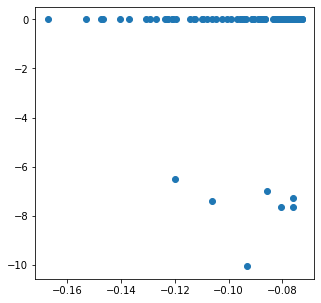




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00150491	0.00479613	-0.0639192	-9.08164e-07
1  	250   	-0.00252884	0.00413996	-0.0213994	-1.91472e-06
2  	250   	-0.0042392 	0.00802936	-0.080245 	-5.56264e-06
3  	250   	-0.00531417	0.00833903	-0.0568765	-2.4382e-06 
4  	250   	-0.00722555	0.00982245	-0.057146 	-7.02187e-06
5  	250   	-0.0118723 	0.0179586 	-0.140747 	-7.75012e-05
6  	250   	-0.0114614 	0.0154201 	-0.123106 	-7.81347e-06
7  	250   	-0.0125963 	0.014906  	-0.11106  	-6.74067e-06
8  	250   	-0.0163215 	0.018686  	-0.149398 	-1.00954e-06
9  	250   	-0.0169861 	0.0177624 	-0.114484 	-2.38437e-05

N pep:  438
Best peptide: -12.163
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 007
N pep under -9 kcal/mol: 011
N pep under -8 kcal/mol: 040
N pep under -7 kcal/mol: 155
N pep under -6 kcal/mol: 192
N pep under -5 kcal/mol: 196
Non binding pep        : 242


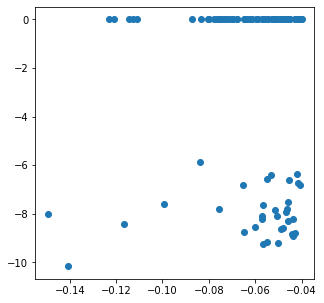




Run: 10
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min     	max         
0  	250   	-0.0261775	0.0196102	-0.13655	-0.000800566
1  	250   	-0.0396605	0.0259392	-0.129916	-0.00372638 
2  	250   	-0.0505783	0.0296536	-0.195784	-0.00928835 
3  	250   	-0.0573201	0.0286027	-0.187655	-0.0093485  
4  	250   	-0.0626611	0.0304858	-0.221584	-0.00951202 
5  	250   	-0.0679244	0.0273176	-0.151854	-0.0111363  
6  	250   	-0.0777584	0.0354468	-0.226409	-0.0171671  
7  	250   	-0.0758343	0.0347138	-0.21083 	-0.0225698  
8  	250   	-0.0794735	0.0353176	-0.205646	-0.0154344  
9  	250   	-0.0836558	0.0351866	-0.228237	-0.0194317  

N pep:  246
Best peptide: -11.235
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 154
Non binding pep        : 092


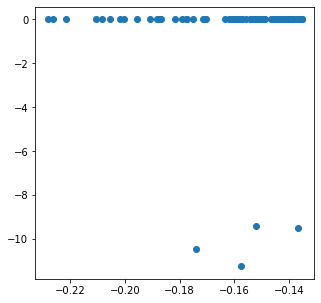




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00584079	0.0120412	-0.084472	-6.24769e-08
1  	250   	-0.0133608 	0.0241526	-0.21615 	-4.33399e-06
2  	250   	-0.0203381 	0.0268377	-0.156789	-5.66343e-05
3  	250   	-0.0326811 	0.0396936	-0.309439	-0.000135501
4  	250   	-0.0495725 	0.0506789	-0.298719	-0.000525876
5  	250   	-0.0652132 	0.0494744	-0.310103	-0.00221846 
6  	250   	-0.0829118 	0.0639947	-0.344188	-0.00287285 
7  	250   	-0.0872727 	0.0611965	-0.46466 	-0.00611111 
8  	250   	-0.0961421 	0.0687224	-0.429148	-0.00504056 
9  	250   	-0.118595  	0.069088 	-0.408982	-0.0119836  

N pep:  342
Best peptide: -11.235
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 131
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 166
Non binding pep        : 176


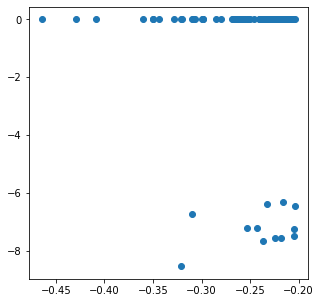




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max         
0  	250   	-0.0034848	0.00666604	-0.0530311	-6.62014e-06
1  	250   	-0.00759841	0.0129203 	-0.0912594	-4.98205e-06
2  	250   	-0.00897988	0.0174996 	-0.159034 	-8.17141e-06
3  	250   	-0.00974242	0.0161879 	-0.124704 	-3.03962e-05
4  	250   	-0.0143435 	0.0205912 	-0.155095 	-6.07424e-05
5  	250   	-0.0167884 	0.0242244 	-0.161055 	-2.5936e-05 
6  	250   	-0.0196915 	0.0237972 	-0.166487 	-5.93638e-05
7  	250   	-0.0197787 	0.0237777 	-0.162066 	-5.10969e-05
8  	250   	-0.0233947 	0.0259469 	-0.179103 	-0.000213943
9  	250   	-0.0234285 	0.0298659 	-0.274098 	-8.09877e-05

N pep:  438
Best peptide: -11.458
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 044
N pep under -7 kcal/mol: 167
N pep under -6 kcal/mol: 206
N pep under -5 kcal/mol: 209
Non binding pep        : 229


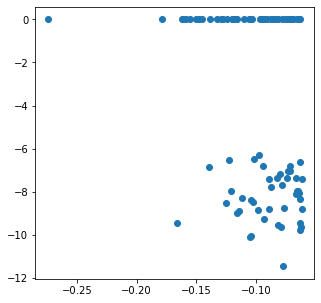

In [23]:
pbil_candidate_fps = []
pbil_candidate_y = []

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    pbil_candidate_fps.append(X_fps_exp.detach().numpy())
    pbil_candidate_y.append(y_exp.detach().numpy())


pbil_candidate_fps = np.array(pbil_candidate_fps)
pbil_candidate_y = np.array(pbil_candidate_y)

### Random candidate peptides sampling

In [24]:
def find_next_candidates_by_random(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    
    sequences = np.array([''.join(s) for s in np.random.choice(AA1, (NGEN * NIND, NLEN))])
    
    sequence_acqs = scorer.evaluate(sequences)
    
    if greater_is_better:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))[::-1]
    else:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))
            
    candidates = sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = sequence_acqs[sorted_peptide_indices[:NCAN]]
                        
    return candidates, candidate_acqs

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.241
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 017
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 148
N pep under -5 kcal/mol: 151
Non binding pep        : 095


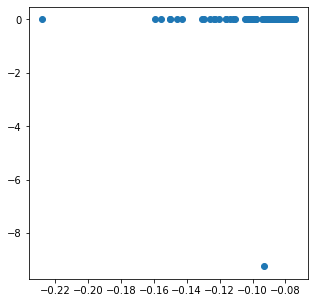




Generation: 2

N pep:  342
Best peptide: -9.395
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 023
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 158
N pep under -5 kcal/mol: 162
Non binding pep        : 180


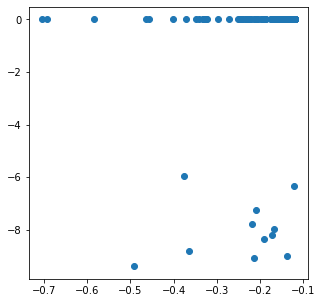




Generation: 3

N pep:  438
Best peptide: -10.590
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 006
N pep under -8 kcal/mol: 030
N pep under -7 kcal/mol: 141
N pep under -6 kcal/mol: 171
N pep under -5 kcal/mol: 175
Non binding pep        : 263


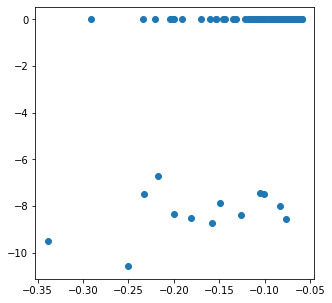




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.388
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 018
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 152
Non binding pep        : 094


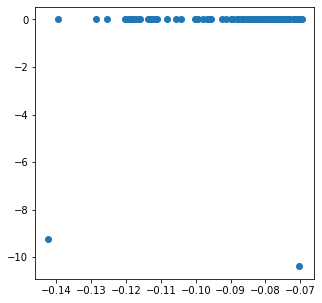




Generation: 2

N pep:  342
Best peptide: -10.491
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 130
N pep under -6 kcal/mol: 158
N pep under -5 kcal/mol: 161
Non binding pep        : 181


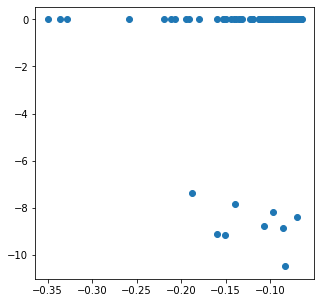




Generation: 3

N pep:  438
Best peptide: -10.491
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 031
N pep under -7 kcal/mol: 138
N pep under -6 kcal/mol: 167
N pep under -5 kcal/mol: 170
Non binding pep        : 268


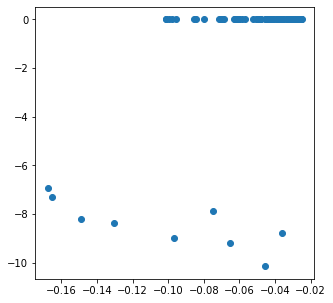




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.556
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 154
Non binding pep        : 092


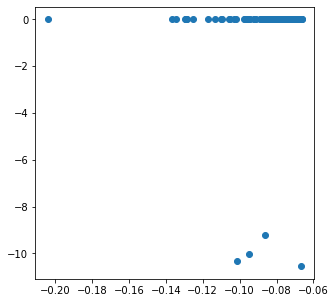




Generation: 2

N pep:  342
Best peptide: -10.556
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 159
N pep under -5 kcal/mol: 162
Non binding pep        : 180


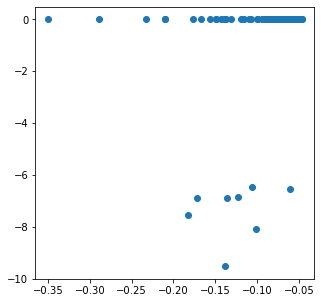




Generation: 3

N pep:  438
Best peptide: -10.556
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 010
N pep under -8 kcal/mol: 030
N pep under -7 kcal/mol: 140
N pep under -6 kcal/mol: 175
N pep under -5 kcal/mol: 178
Non binding pep        : 260


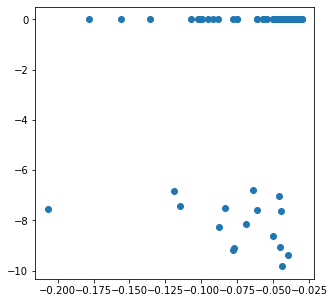




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.653
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 017
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 148
N pep under -5 kcal/mol: 151
Non binding pep        : 095


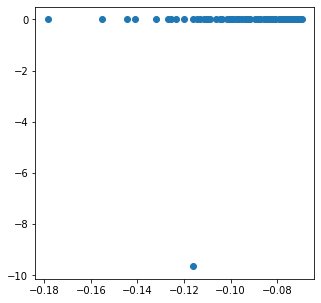




Generation: 2

N pep:  342
Best peptide: -9.653
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 153
N pep under -5 kcal/mol: 156
Non binding pep        : 186


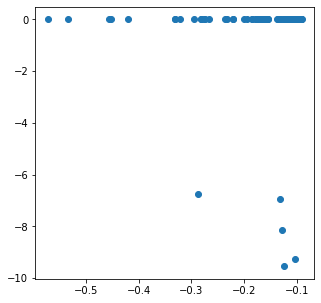




Generation: 3

N pep:  438
Best peptide: -9.653
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 135
N pep under -6 kcal/mol: 167
N pep under -5 kcal/mol: 170
Non binding pep        : 268


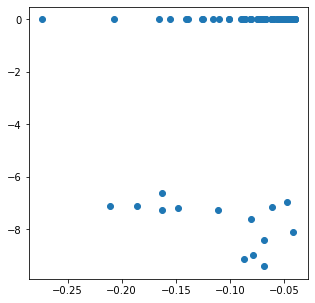




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.336
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 154
Non binding pep        : 092


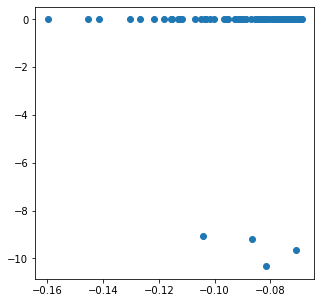




Generation: 2

N pep:  342
Best peptide: -10.336
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 155
N pep under -5 kcal/mol: 158
Non binding pep        : 184


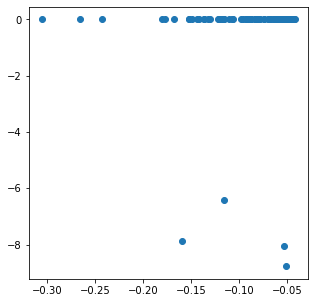




Generation: 3

N pep:  438
Best peptide: -10.666
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 007
N pep under -8 kcal/mol: 029
N pep under -7 kcal/mol: 136
N pep under -6 kcal/mol: 167
N pep under -5 kcal/mol: 170
Non binding pep        : 268


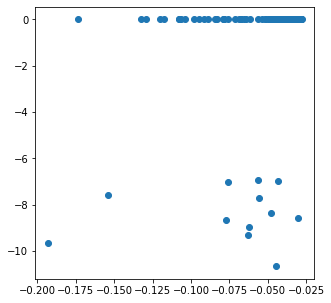




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.597
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 019
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 153
Non binding pep        : 093


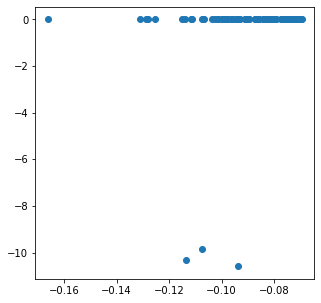




Generation: 2

N pep:  342
Best peptide: -10.597
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 019
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 153
N pep under -5 kcal/mol: 156
Non binding pep        : 186


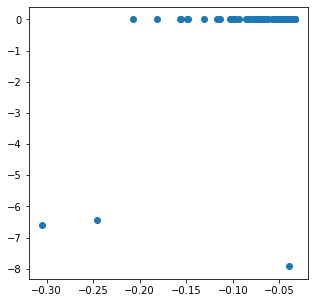




Generation: 3

N pep:  438
Best peptide: -10.597
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 131
N pep under -6 kcal/mol: 162
N pep under -5 kcal/mol: 165
Non binding pep        : 273


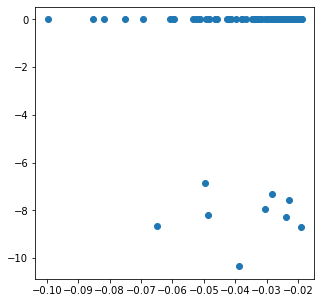




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.704
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 019
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 153
Non binding pep        : 093


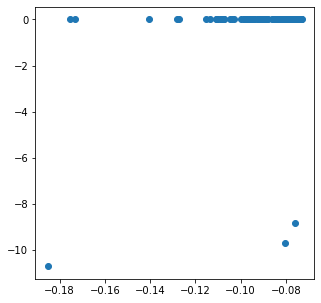




Generation: 2

N pep:  342
Best peptide: -10.704
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 019
N pep under -7 kcal/mol: 127
N pep under -6 kcal/mol: 155
N pep under -5 kcal/mol: 158
Non binding pep        : 184


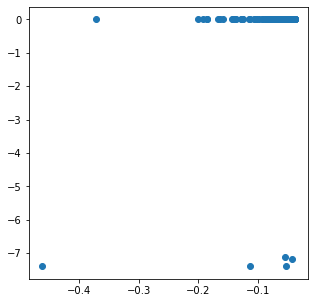




Generation: 3

N pep:  438
Best peptide: -10.704
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 024
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 164
N pep under -5 kcal/mol: 167
Non binding pep        : 271


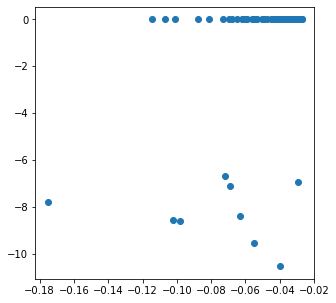




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 096


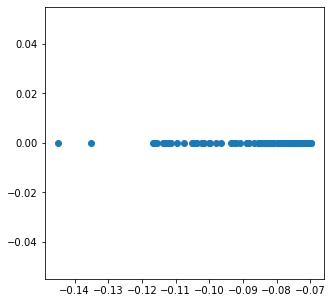




Generation: 2

N pep:  342
Best peptide: -9.231
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 018
N pep under -7 kcal/mol: 126
N pep under -6 kcal/mol: 157
N pep under -5 kcal/mol: 160
Non binding pep        : 182


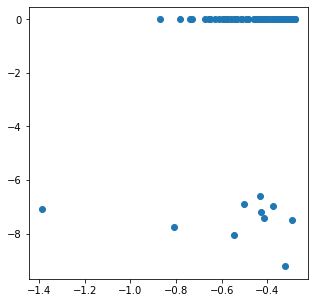




Generation: 3

N pep:  438
Best peptide: -10.336
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 005
N pep under -8 kcal/mol: 025
N pep under -7 kcal/mol: 136
N pep under -6 kcal/mol: 167
N pep under -5 kcal/mol: 170
Non binding pep        : 268


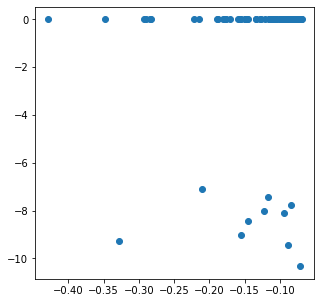




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.736
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 018
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 149
N pep under -5 kcal/mol: 152
Non binding pep        : 094


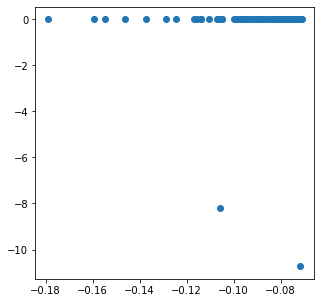




Generation: 2

N pep:  342
Best peptide: -10.736
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 022
N pep under -7 kcal/mol: 129
N pep under -6 kcal/mol: 159
N pep under -5 kcal/mol: 162
Non binding pep        : 180


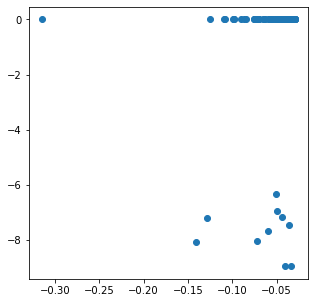




Generation: 3

N pep:  438
Best peptide: -10.736
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 027
N pep under -7 kcal/mol: 140
N pep under -6 kcal/mol: 172
N pep under -5 kcal/mol: 175
Non binding pep        : 263


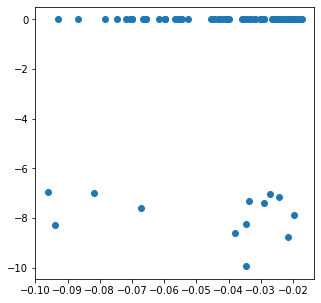




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.192
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 016
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 147
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.373
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 003
N pep under -8 kcal/mol: 019
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 150
N pep under -5 kcal/mol: 153
Non binding pep        : 093


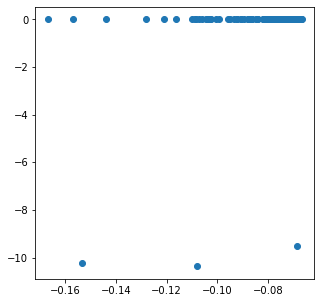




Generation: 2

N pep:  342
Best peptide: -10.373
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 004
N pep under -8 kcal/mol: 020
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 154
N pep under -5 kcal/mol: 157
Non binding pep        : 185


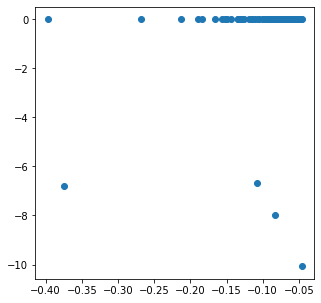




Generation: 3

N pep:  438
Best peptide: -10.373
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 008
N pep under -8 kcal/mol: 028
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 165
N pep under -5 kcal/mol: 168
Non binding pep        : 270


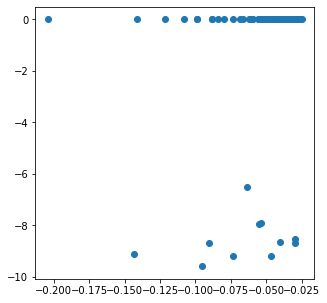

In [25]:
random_candidate_fps = []
random_candidate_y = []

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates_by_random(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    random_candidate_fps.append(X_fps_exp.detach().numpy())
    random_candidate_y.append(y_exp.detach().numpy())


random_candidate_fps = np.array(random_candidate_fps)
random_candidate_y = np.array(random_candidate_y)

### Candidate peptides sampling with custom GA

In [110]:
def parse_helm(helm_string):
    dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
             ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
             ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
    
    polymers, connections, hydrogen_bonds, attributes, _ = helm_string.split('$')
    
    # Process sequences
    data = {}
    for polymer in polymers.split('|'):
        pid = polymer.split('{')[0]
        sequence = polymer[len(pid) + 1:-1].replace('.', '')
        data[pid] = sequence
        
    polymers = data
        
    # Process connections
    data = []
    if connections:
        for connection in connections.split('|'):
            source_id, target_id, con = connection.split(',')
            source_position, source_attachment = con.split('-')[0].split(':')
            target_position, target_attachment = con.split('-')[1].split(':')
            data.append((source_id, target_id,
                         source_position, source_attachment,
                         target_position, target_attachment))
        
    connections = np.array(data, dtype=dtype)
    
    return polymers, connections, hydrogen_bonds, attributes


class HELMGeneticOperators:
    
    def __init__(self, monomer_library, probability_matrix=None, seed=None):
        self._monomer_library = monomer_library
        self._monomer_symbols = [m['symbol'] for m in self._monomer_library]
        self._probability_matrix = probability_matrix
        
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

    def mutate(self, helm_string, n=10, minimum_mutations=1, maximum_mutations=None, keep_connections=True):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
            
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)
                
                # Residues involved in a connection within and between peptides won't be mutated
                if keep_connections and pid in polymers.keys():
                    connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                    connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                    # Because positions are 1-based in HELM
                    connection_resids = np.array(connection_resids) - 1
                    
                    possible_positions = list(set(range(len(sequence))).difference(connection_resids))
                else:
                    possible_positions = list(range(len(sequence)))
                
                # Choose a random number of mutations between min and max
                if minimum_mutations == maximum_mutations:
                    number_mutations = maximum_mutations
                elif maximum_mutations is None:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=len(sequence))
                else:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=maximum_mutations)
                
                # Choose positions to mutate
                mutation_positions = self._rng.choice(possible_positions, size=number_mutations, replace=False)
                
                # Do mutations
                for mutation_position in mutation_positions:                    
                    monomer_symbol = mutated_sequence[mutation_position]
                    
                    # Force mutation!
                    while monomer_symbol == mutated_sequence[mutation_position]:
                        # Instead of mutating to random monomer, the selection will be
                        # based on the probability matrix
                        if self._probability_matrix is not None:
                            index_symbol = self._monomer_symbols.index(monomer_symbol)
                            p = probability_matrix[index_symbol]
                        else:
                            p = None
                        
                        chosen_monomer = self._rng.choice(self._monomer_symbols, p=p)
                        mutated_sequence[mutation_position] = chosen_monomer
                
                mutant_polymers[pid] = (mutated_sequence, mutation_positions)
                n_mutations += len(mutation_positions)
            
            if n_mutations > 0:
                if not keep_connections:
                    connections_to_keep = []

                    # Check if we have to remove connections due to the mutations
                    for i, connection in enumerate(connections):
                        # The connection positions must not be in the mutation lists
                        # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                        if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                           connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                            connections_to_keep.append(i)
                else:
                    connections_to_keep = list(range(connections.shape[0]))

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, connections[connections_to_keep])
                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings
            

In [51]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

smiles = [monomer['smiles'] for monomer in monomer_aa1_lib]
fps = map4_fingerprint(smiles,input_type='smiles', radius=2)
t = TanimotoSimilarityKernel()
similarity_matrix = t.forward(fps, fps).numpy()

probability_matrix = []

for aa in similarity_matrix:
    tmp = aa.copy()
    tmp[tmp == 1.0] = 0
    probability_matrix.append(tmp / np.sum(tmp))
    
probability_matrix = np.array(probability_matrix)

In [50]:
def find_next_candidates_with_custom_GA(scorer, best_peptide, monomer_lib, probability_matrix, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    
    polymers = {'PEPTIDE1': best_peptide}
    helm_string = build_helm_string(polymers, [])
    m = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)
    
    all_sequences = []
    all_sequence_acqs = []
    
    for i in range(NGEN):
        sequences = m.mutate(helm_string, n=NIND, minimum_mutations=1, maximum_mutations=2)
        sequence_acqs = scorer.evaluate(sequences)
        
        # Take the best peptide
        if greater_is_better:
            seq_idx = np.argmax(np.ravel(sequence_acqs))
        else:
            seq_idx = np.argmin(np.ravel(sequence_acqs))
            
        helm_string = sequences[seq_idx]
        
        all_sequences.extend(sequences)
        all_sequence_acqs.extend(np.ravel(sequence_acqs))
        
    # Remove duplicates
    all_sequences, indices = np.unique(all_sequences, return_index=True)
    all_sequence_acqs = np.array(all_sequence_acqs)[indices]
        
    if greater_is_better:
        sorted_peptide_indices = np.argsort(all_sequence_acqs)[::-1]
    else:
        sorted_peptide_indices = np.argsort(all_sequence_acqs)
    
    # Select candidates
    candidates = all_sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = all_sequence_acqs[sorted_peptide_indices[:NCAN]]
    
    # Convert HELM to FASTA
    candidates = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidates]
                        
    return candidates, candidate_acqs

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.750
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 041
N pep under -10 kcal/mol: 090
N pep under -9 kcal/mol: 094
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


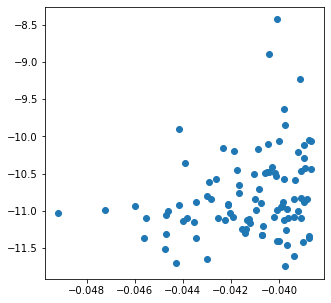




Generation: 2

N pep:  342
Best peptide: -13.047
N pep under -12 kcal/mol: 077
N pep under -11 kcal/mol: 137
N pep under -10 kcal/mol: 186
N pep under -9 kcal/mol: 190
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


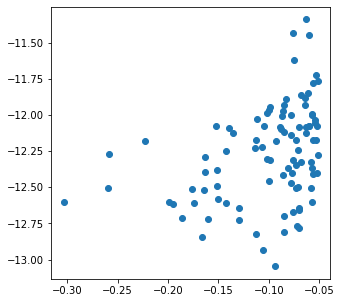




Generation: 3

N pep:  438
Best peptide: -13.645
N pep under -12 kcal/mol: 173
N pep under -11 kcal/mol: 233
N pep under -10 kcal/mol: 282
N pep under -9 kcal/mol: 286
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


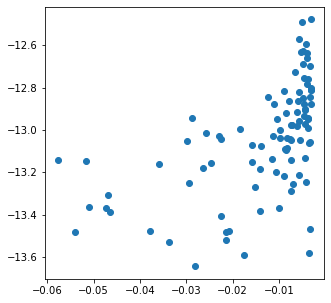




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.804
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 049
N pep under -10 kcal/mol: 092
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


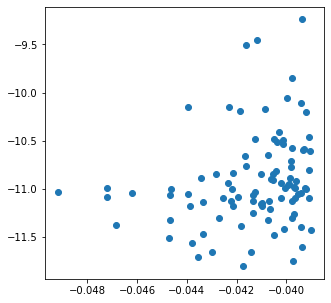




Generation: 2

N pep:  342
Best peptide: -13.142
N pep under -12 kcal/mol: 074
N pep under -11 kcal/mol: 145
N pep under -10 kcal/mol: 188
N pep under -9 kcal/mol: 192
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


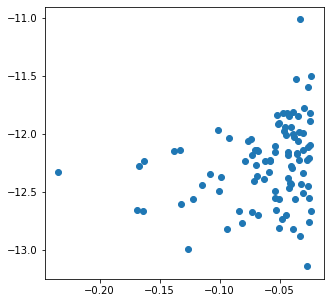




Generation: 3

N pep:  438
Best peptide: -13.951
N pep under -12 kcal/mol: 170
N pep under -11 kcal/mol: 241
N pep under -10 kcal/mol: 284
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


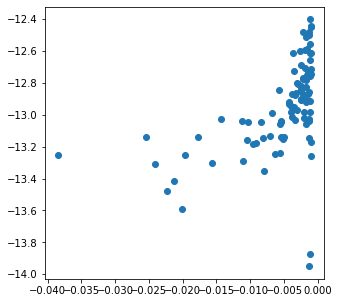




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.709
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 043
N pep under -10 kcal/mol: 091
N pep under -9 kcal/mol: 094
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


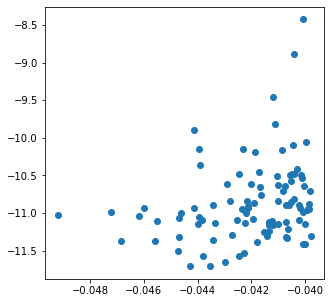




Generation: 2

N pep:  342
Best peptide: -13.056
N pep under -12 kcal/mol: 081
N pep under -11 kcal/mol: 139
N pep under -10 kcal/mol: 187
N pep under -9 kcal/mol: 190
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


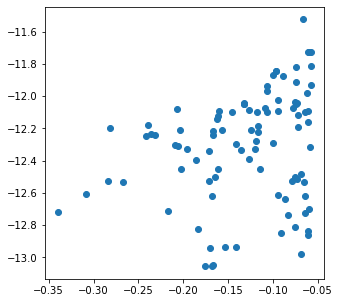




Generation: 3

N pep:  438
Best peptide: -13.649
N pep under -12 kcal/mol: 175
N pep under -11 kcal/mol: 235
N pep under -10 kcal/mol: 283
N pep under -9 kcal/mol: 286
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


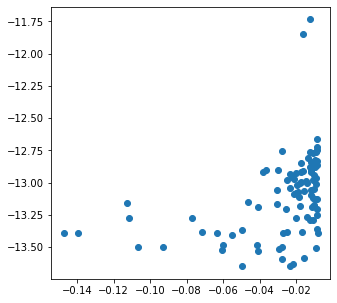




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.750
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 030
N pep under -10 kcal/mol: 093
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


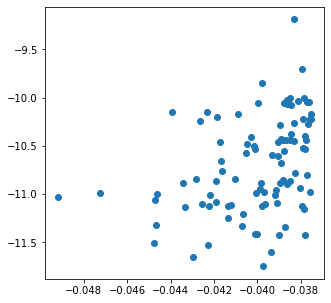




Generation: 2

N pep:  342
Best peptide: -13.142
N pep under -12 kcal/mol: 071
N pep under -11 kcal/mol: 124
N pep under -10 kcal/mol: 189
N pep under -9 kcal/mol: 192
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


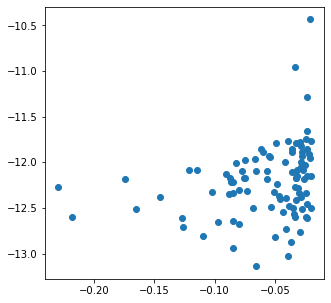




Generation: 3

N pep:  438
Best peptide: -13.645
N pep under -12 kcal/mol: 167
N pep under -11 kcal/mol: 220
N pep under -10 kcal/mol: 285
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


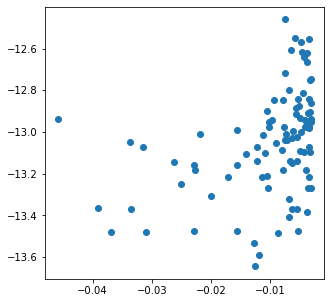




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.804
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 031
N pep under -10 kcal/mol: 091
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


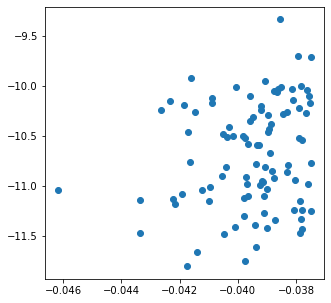




Generation: 2

N pep:  342
Best peptide: -13.142
N pep under -12 kcal/mol: 073
N pep under -11 kcal/mol: 127
N pep under -10 kcal/mol: 187
N pep under -9 kcal/mol: 192
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


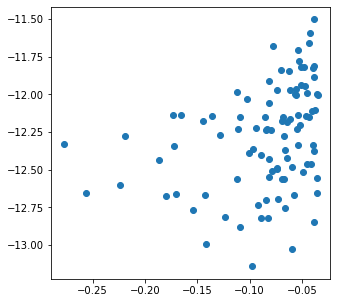




Generation: 3

N pep:  438
Best peptide: -13.672
N pep under -12 kcal/mol: 167
N pep under -11 kcal/mol: 223
N pep under -10 kcal/mol: 283
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


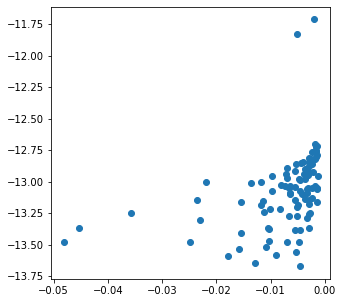




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.750
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 010
N pep under -10 kcal/mol: 075
N pep under -9 kcal/mol: 094
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


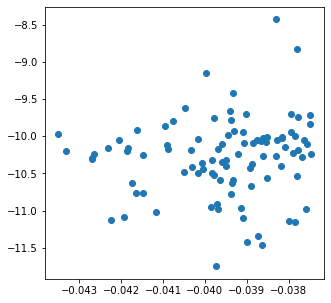




Generation: 2

N pep:  342
Best peptide: -13.142
N pep under -12 kcal/mol: 070
N pep under -11 kcal/mol: 106
N pep under -10 kcal/mol: 171
N pep under -9 kcal/mol: 190
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


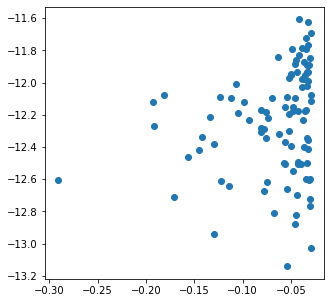




Generation: 3

N pep:  438
Best peptide: -13.590
N pep under -12 kcal/mol: 160
N pep under -11 kcal/mol: 199
N pep under -10 kcal/mol: 267
N pep under -9 kcal/mol: 286
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


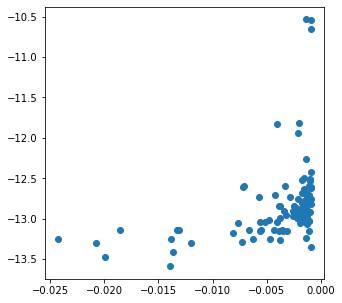




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.750
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 015
N pep under -10 kcal/mol: 085
N pep under -9 kcal/mol: 094
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


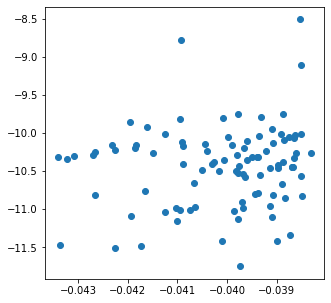




Generation: 2

N pep:  342
Best peptide: -13.142
N pep under -12 kcal/mol: 079
N pep under -11 kcal/mol: 111
N pep under -10 kcal/mol: 181
N pep under -9 kcal/mol: 190
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


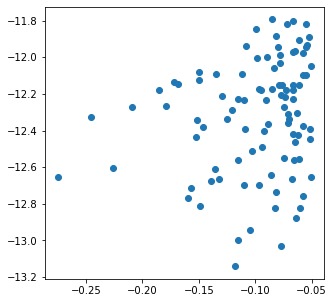




Generation: 3

N pep:  438
Best peptide: -13.590
N pep under -12 kcal/mol: 172
N pep under -11 kcal/mol: 207
N pep under -10 kcal/mol: 277
N pep under -9 kcal/mol: 286
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


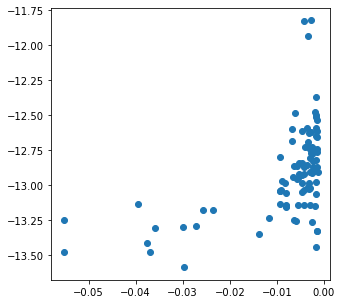




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.178
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 047
N pep under -10 kcal/mol: 093
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


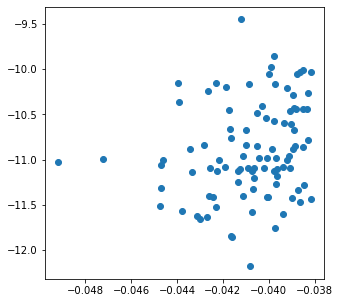




Generation: 2

N pep:  342
Best peptide: -13.251
N pep under -12 kcal/mol: 091
N pep under -11 kcal/mol: 142
N pep under -10 kcal/mol: 189
N pep under -9 kcal/mol: 192
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


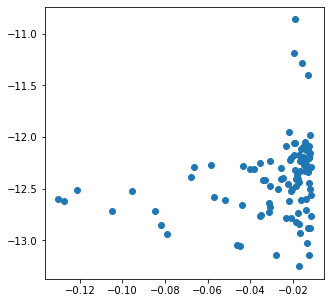




Generation: 3

N pep:  438
Best peptide: -14.225
N pep under -12 kcal/mol: 187
N pep under -11 kcal/mol: 238
N pep under -10 kcal/mol: 285
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


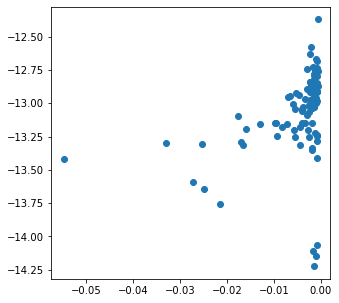




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.178
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 042
N pep under -10 kcal/mol: 089
N pep under -9 kcal/mol: 093
N pep under -8 kcal/mol: 098
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


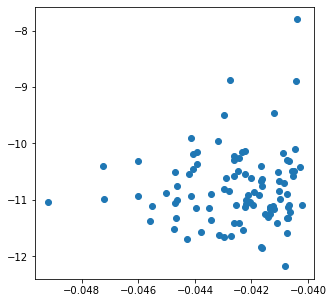




Generation: 2

N pep:  342
Best peptide: -13.427
N pep under -12 kcal/mol: 091
N pep under -11 kcal/mol: 138
N pep under -10 kcal/mol: 185
N pep under -9 kcal/mol: 189
N pep under -8 kcal/mol: 194
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


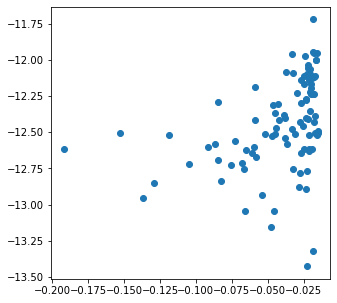




Generation: 3

N pep:  438
Best peptide: -14.225
N pep under -12 kcal/mol: 187
N pep under -11 kcal/mol: 234
N pep under -10 kcal/mol: 281
N pep under -9 kcal/mol: 285
N pep under -8 kcal/mol: 290
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


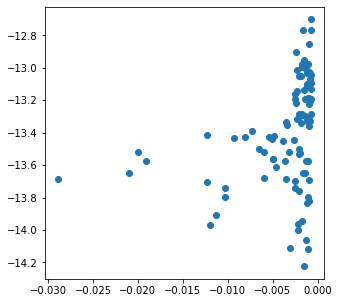




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.178
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 049
N pep under -10 kcal/mol: 093
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


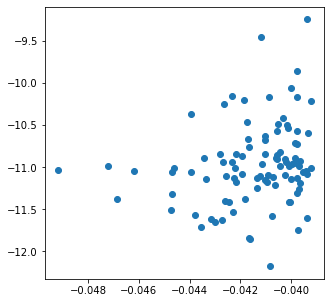




Generation: 2

N pep:  342
Best peptide: -13.251
N pep under -12 kcal/mol: 094
N pep under -11 kcal/mol: 145
N pep under -10 kcal/mol: 189
N pep under -9 kcal/mol: 192
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


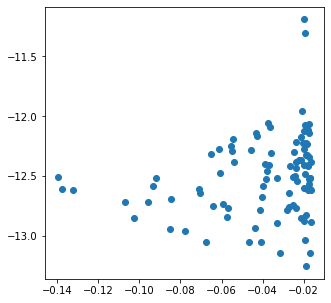




Generation: 3

N pep:  438
Best peptide: -14.225
N pep under -12 kcal/mol: 190
N pep under -11 kcal/mol: 241
N pep under -10 kcal/mol: 285
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


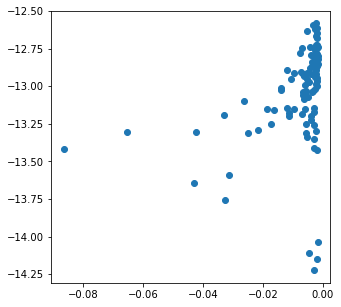

In [52]:
custom_candidate_fps = []
custom_candidate_y = []

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Get best random peptide
    candidates = list(random_peptides)
    best_peptide = random_peptides[np.argmin(random_peptide_scores)]
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm')
        candidate_sequences, candidates_acq = find_next_candidates_with_custom_GA(acq, best_peptide, monomer_aa1_lib, probability_matrix, greater_is_better=False)
        
        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])
        
        # Get best peptide found so far
        candidates.extend(candidate_sequences)
        best_peptide = np.array(candidates)[np.argmin(y_exp.numpy())]

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    custom_candidate_fps.append(X_fps_exp.detach().numpy())
    custom_candidate_y.append(y_exp.detach().numpy())


custom_candidate_fps = np.array(custom_candidate_fps)
custom_candidate_y = np.array(custom_candidate_y)

### Candidate peptides sampling with Adaptive GA (mutations only)

In [34]:
def aga_mutation(fitness_score, k2=0.5, k4=0.5):
    f_max = np.max(fitness_score)
    f_mean = np.mean(fitness_score)
    
    # Compute mutation probabilities
    pm = k2 * (f_max - fitness_score) / (f_max - f_mean)
    #pm[fitness_score < f_mean] = k4
    
    # Select individuals eligible for mutations
    r = np.random.uniform(0, 1, size=len(fitness_score))
    results = r <= pm
    
    return results


i = np.arange(10)
f = np.sort(np.random.uniform(0, 1, size=i.shape[0]))

print(aga_mutation(f, 1, 1))

[ True  True  True  True  True  True False  True False False]


In [35]:
def select_random_Ns(lst, n):
    np.random.shuffle(lst)
    result = []
    for i in range(0, len(lst), n):
        result.append(lst[i:i + n])
    return result


def aga_crossover(fitness_score, k1=1.0, k3=1.0):
    f_max = np.max(fitness_score)
    f_mean = np.mean(fitness_score)
    
    # Compute crossover probabilities
    pc = k1 * (f_max - fitness_score) / (f_max - f_mean)
    pc[fitness_score < f_mean] = k3
    
    # Select individual to crossover
    i = np.arange(len(fitness_score))
    r = np.random.uniform(0, 1, size=len(fitness_score))    
    indv = i[r <= pc]

    # Create crossover pairs
    pairs = select_random_Ns(indv, 2)
    
    return pairs


i = np.arange(10)
f = np.sort(np.random.uniform(0, 1, size=10))

print(aga_crossover(f))

[array([0, 4]), array([7, 5]), array([3, 2]), array([1])]


In [178]:
class LocalGAOptimization:
    
    def __init__(self, scorer, monomer_lib, probability_matrix, n_gen=3, n_children=250, sigma=0.08, greater_is_better=True):
        self._n_gen = n_gen
        self._n_children = n_children
        self._sigma = sigma
        self._greater_is_better = greater_is_better
        
        self._scorer = scorer
        self._HELMGO = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)
        
        self.candidates = None
        self.candidate_scores = None

    def _number_of_children_to_generate_per_parent(self, parent_scores, greater_is_better=True):
        """Compute the number of children generated by each parent sequence 
        based on their acquisition score using RBF weighting.
        """
        i = 0

        if greater_is_better == False:
            p = np.abs(parent_scores)

        # Normalize score between 0 and 1 because of the exponential
        p = (p - np.min(p)) / (np.max(p) - np.min(p))
        # RBF
        children_per_parent = self._n_children * np.exp(p**2 / (2 * self._sigma**2)) / np.sum(np.exp(p**2 / (2 * self._sigma**2)))
        children_per_parent = np.round(children_per_parent).astype(int)

        # Add 1 until the number of children is equal to n_children
        parent_indices = np.argwhere(children_per_parent > 0).flatten()

        while np.sum(children_per_parent) < self._n_children:
            try:
                if children_per_parent[parent_indices[i]] > 0:
                    children_per_parent[parent_indices[i]] += 1
                    i += 1
            except:
                # we restart from the beginning if we reach the end
                i = 0

        return children_per_parent

    def _generate_new_population(self, parents, parent_scores, greater_is_better=True):
        new_pop = []

        # Compute the number of children generated by each parent sequence based on their acquisition score
        children_per_parent = self._number_of_children_to_generate_per_parent(parent_scores, greater_is_better)

        parent_indices = np.argwhere(children_per_parent > 0).flatten()

        for i in parent_indices:
            """ If there is only one copy for that peptide, parent is replaced by the child.
            Otherwise, one child or more is generated by mutation and the parent is conserved to 
            the next generation
            """
            if children_per_parent[i] == 1:
                new_pop.extend(self._HELMGO.mutate(parents[i], n=children_per_parent[i], minimum_mutations=1, maximum_mutations=2))
            else:
                new_pop.append(parents[i])
                new_pop.extend(self._HELMGO.mutate(parents[i], n=children_per_parent[i] - 1, minimum_mutations=1, maximum_mutations=2))

        return new_pop

    def run(self, init_population, init_scores):
        self.candidates = None
        self.candidate_scores = None
        all_sequences = []
        all_sequence_scores = []

        # Generate new population
        sequences = self._generate_new_population(init_population, init_scores, False)
        # Remove duplicates
        # That is inefficient because there is a strong chance that will have less than NIND children...
        sequences = np.unique(sequences)
        # Evaluate the population
        sequence_scores = self._scorer.evaluate(sequences)

        for i in range(self._n_gen):    
            # Generate new population
            sequences = self._generate_new_population(sequences, sequence_scores, self._greater_is_better)
            # Remove duplicates
            # That is inefficient because there is a strong chance that will have less than NIND children...
            sequences = np.unique(sequences)
            # Evaluate the population
            sequence_scores = self._scorer.evaluate(sequences)

            all_sequences.extend(sequences)
            all_sequence_scores.extend(np.ravel(sequence_scores))

        # Remove duplicates
        all_sequences, unique_indices = np.unique(all_sequences, return_index=True)
        all_sequence_scores = np.array(all_sequence_scores)[unique_indices]
        
        # Sort candidates by scores in the decreasing order (best to worst)
        if self._greater_is_better:
            sorted_indices = np.argsort(all_sequence_scores)[::-1]
        else:
            sorted_indices = np.argsort(all_sequence_scores)
        
        self.candidates = all_sequences[sorted_indices]
        self.candidate_scores = all_sequence_scores[sorted_indices]


Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.491
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 008
N pep under -11 kcal/mol: 036
N pep under -10 kcal/mol: 064
N pep under -9 kcal/mol: 078
N pep under -8 kcal/mol: 094
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


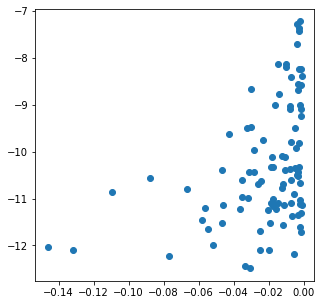




Generation: 2

N pep:  342
Best peptide: -13.221
N pep under -13 kcal/mol: 007
N pep under -12 kcal/mol: 083
N pep under -11 kcal/mol: 132
N pep under -10 kcal/mol: 160
N pep under -9 kcal/mol: 174
N pep under -8 kcal/mol: 190
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


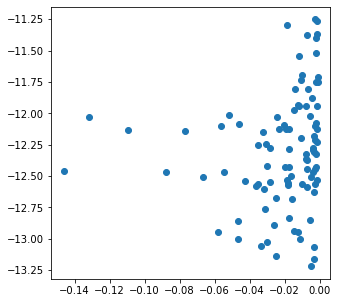




Generation: 3

N pep:  438
Best peptide: -14.064
N pep under -13 kcal/mol: 067
N pep under -12 kcal/mol: 173
N pep under -11 kcal/mol: 224
N pep under -10 kcal/mol: 256
N pep under -9 kcal/mol: 270
N pep under -8 kcal/mol: 286
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


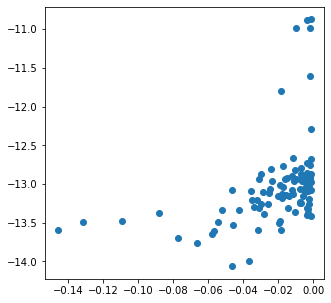




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.732
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 007
N pep under -10 kcal/mol: 019
N pep under -9 kcal/mol: 046
N pep under -8 kcal/mol: 089
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


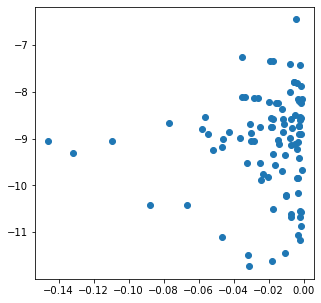




Generation: 2

N pep:  342
Best peptide: -12.352
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 012
N pep under -11 kcal/mol: 101
N pep under -10 kcal/mol: 115
N pep under -9 kcal/mol: 142
N pep under -8 kcal/mol: 185
N pep under -7 kcal/mol: 229
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


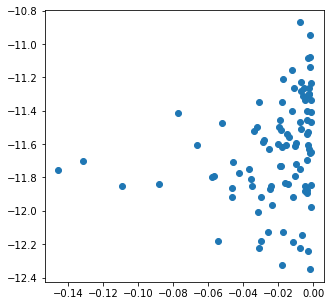




Generation: 3

N pep:  438
Best peptide: -13.417
N pep under -13 kcal/mol: 005
N pep under -12 kcal/mol: 107
N pep under -11 kcal/mol: 197
N pep under -10 kcal/mol: 211
N pep under -9 kcal/mol: 238
N pep under -8 kcal/mol: 281
N pep under -7 kcal/mol: 325
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


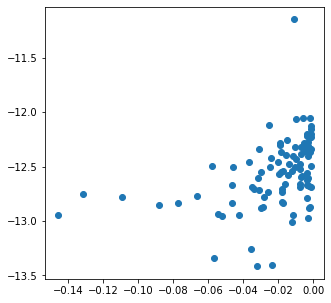




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.996
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 018
N pep under -10 kcal/mol: 054
N pep under -9 kcal/mol: 080
N pep under -8 kcal/mol: 097
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


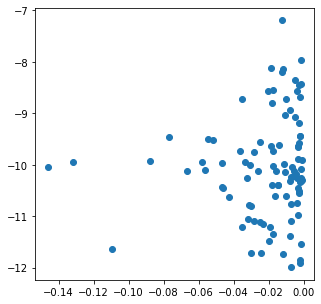




Generation: 2

N pep:  342
Best peptide: -13.371
N pep under -13 kcal/mol: 005
N pep under -12 kcal/mol: 065
N pep under -11 kcal/mol: 114
N pep under -10 kcal/mol: 150
N pep under -9 kcal/mol: 176
N pep under -8 kcal/mol: 193
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


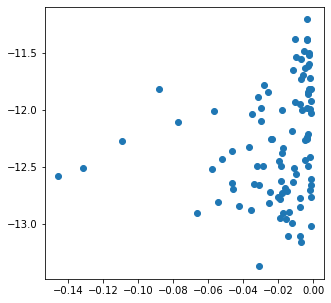




Generation: 3

N pep:  438
Best peptide: -13.955
N pep under -13 kcal/mol: 084
N pep under -12 kcal/mol: 161
N pep under -11 kcal/mol: 210
N pep under -10 kcal/mol: 246
N pep under -9 kcal/mol: 272
N pep under -8 kcal/mol: 289
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


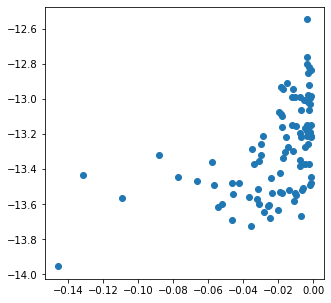




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.257
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 023
N pep under -10 kcal/mol: 057
N pep under -9 kcal/mol: 081
N pep under -8 kcal/mol: 098
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


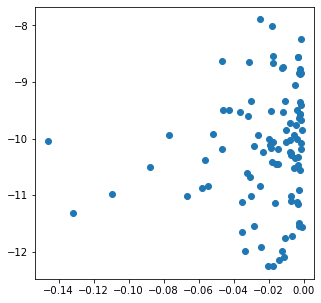




Generation: 2

N pep:  342
Best peptide: -13.221
N pep under -13 kcal/mol: 004
N pep under -12 kcal/mol: 087
N pep under -11 kcal/mol: 114
N pep under -10 kcal/mol: 151
N pep under -9 kcal/mol: 177
N pep under -8 kcal/mol: 194
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


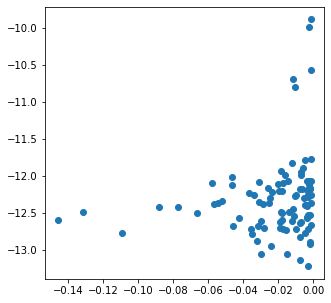




Generation: 3

N pep:  438
Best peptide: -13.649
N pep under -13 kcal/mol: 041
N pep under -12 kcal/mol: 183
N pep under -11 kcal/mol: 210
N pep under -10 kcal/mol: 247
N pep under -9 kcal/mol: 273
N pep under -8 kcal/mol: 290
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


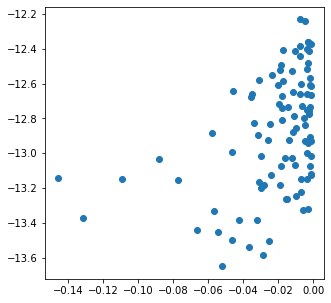




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.758
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 010
N pep under -10 kcal/mol: 036
N pep under -9 kcal/mol: 053
N pep under -8 kcal/mol: 093
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


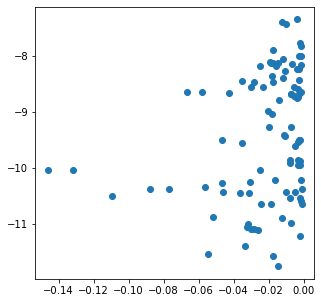




Generation: 2

N pep:  342
Best peptide: -12.570
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 054
N pep under -11 kcal/mol: 106
N pep under -10 kcal/mol: 132
N pep under -9 kcal/mol: 149
N pep under -8 kcal/mol: 189
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


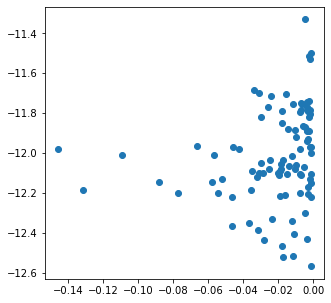




Generation: 3

N pep:  438
Best peptide: -13.490
N pep under -13 kcal/mol: 032
N pep under -12 kcal/mol: 150
N pep under -11 kcal/mol: 202
N pep under -10 kcal/mol: 228
N pep under -9 kcal/mol: 245
N pep under -8 kcal/mol: 285
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


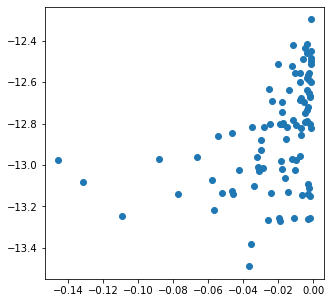




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.194
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 016
N pep under -10 kcal/mol: 019
N pep under -9 kcal/mol: 027
N pep under -8 kcal/mol: 055
N pep under -7 kcal/mol: 130
N pep under -6 kcal/mol: 189
N pep under -5 kcal/mol: 246
Non binding pep        : 000


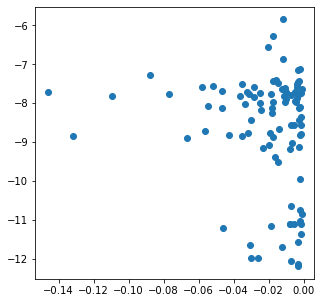




Generation: 2

N pep:  342
Best peptide: -13.081
N pep under -13 kcal/mol: 002
N pep under -12 kcal/mol: 051
N pep under -11 kcal/mol: 110
N pep under -10 kcal/mol: 115
N pep under -9 kcal/mol: 123
N pep under -8 kcal/mol: 151
N pep under -7 kcal/mol: 226
N pep under -6 kcal/mol: 285
N pep under -5 kcal/mol: 342
Non binding pep        : 000


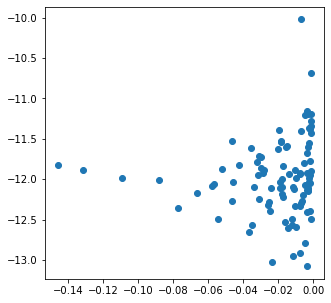




Generation: 3

N pep:  438
Best peptide: -13.759
N pep under -13 kcal/mol: 034
N pep under -12 kcal/mol: 146
N pep under -11 kcal/mol: 206
N pep under -10 kcal/mol: 211
N pep under -9 kcal/mol: 219
N pep under -8 kcal/mol: 247
N pep under -7 kcal/mol: 322
N pep under -6 kcal/mol: 381
N pep under -5 kcal/mol: 438
Non binding pep        : 000


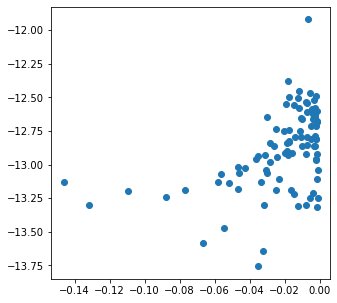




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.982
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 027
N pep under -10 kcal/mol: 063
N pep under -9 kcal/mol: 078
N pep under -8 kcal/mol: 095
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


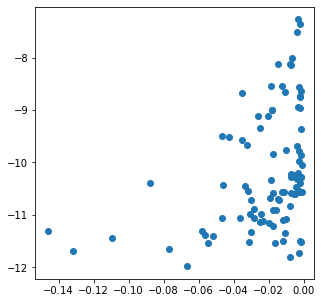




Generation: 2

N pep:  342
Best peptide: -13.218
N pep under -13 kcal/mol: 002
N pep under -12 kcal/mol: 087
N pep under -11 kcal/mol: 123
N pep under -10 kcal/mol: 159
N pep under -9 kcal/mol: 174
N pep under -8 kcal/mol: 191
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


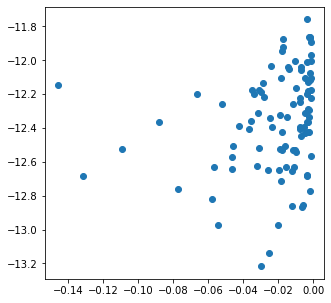




Generation: 3

N pep:  438
Best peptide: -13.492
N pep under -13 kcal/mol: 056
N pep under -12 kcal/mol: 183
N pep under -11 kcal/mol: 219
N pep under -10 kcal/mol: 255
N pep under -9 kcal/mol: 270
N pep under -8 kcal/mol: 287
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


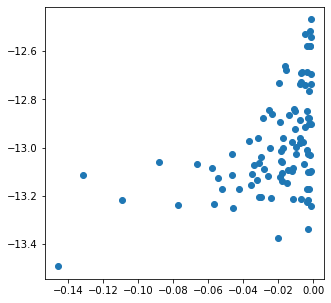




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.721
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 015
N pep under -10 kcal/mol: 032
N pep under -9 kcal/mol: 045
N pep under -8 kcal/mol: 089
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


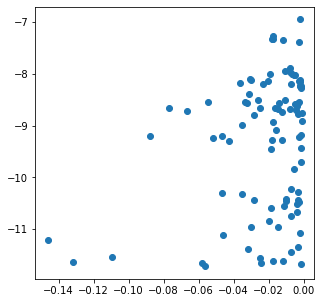




Generation: 2

N pep:  342
Best peptide: -12.694
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 038
N pep under -11 kcal/mol: 111
N pep under -10 kcal/mol: 128
N pep under -9 kcal/mol: 141
N pep under -8 kcal/mol: 185
N pep under -7 kcal/mol: 229
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


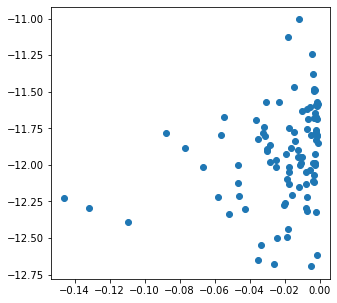




Generation: 3

N pep:  438
Best peptide: -13.688
N pep under -13 kcal/mol: 028
N pep under -12 kcal/mol: 130
N pep under -11 kcal/mol: 206
N pep under -10 kcal/mol: 224
N pep under -9 kcal/mol: 237
N pep under -8 kcal/mol: 281
N pep under -7 kcal/mol: 325
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


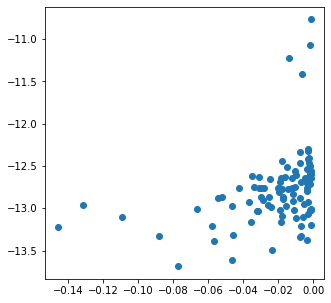




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.982
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 013
N pep under -10 kcal/mol: 020
N pep under -9 kcal/mol: 038
N pep under -8 kcal/mol: 089
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


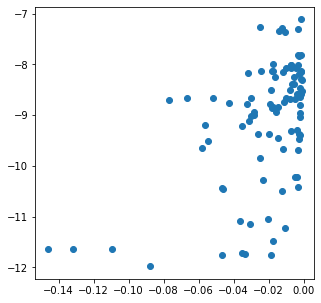




Generation: 2

N pep:  342
Best peptide: -13.086
N pep under -13 kcal/mol: 001
N pep under -12 kcal/mol: 058
N pep under -11 kcal/mol: 106
N pep under -10 kcal/mol: 116
N pep under -9 kcal/mol: 134
N pep under -8 kcal/mol: 185
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


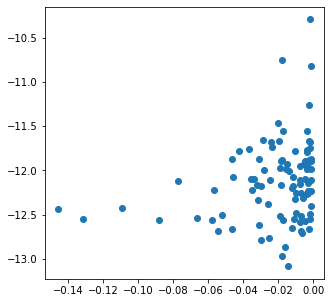




Generation: 3

N pep:  438
Best peptide: -13.607
N pep under -13 kcal/mol: 037
N pep under -12 kcal/mol: 154
N pep under -11 kcal/mol: 202
N pep under -10 kcal/mol: 212
N pep under -9 kcal/mol: 230
N pep under -8 kcal/mol: 281
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


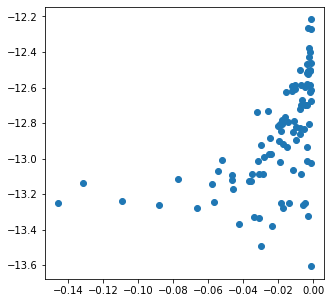




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.137
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.243
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 014
N pep under -10 kcal/mol: 020
N pep under -9 kcal/mol: 030
N pep under -8 kcal/mol: 059
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 189
N pep under -5 kcal/mol: 246
Non binding pep        : 000


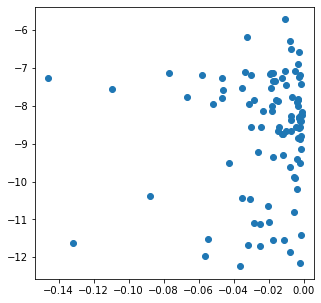




Generation: 2

N pep:  342
Best peptide: -12.799
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 074
N pep under -11 kcal/mol: 110
N pep under -10 kcal/mol: 116
N pep under -9 kcal/mol: 126
N pep under -8 kcal/mol: 155
N pep under -7 kcal/mol: 224
N pep under -6 kcal/mol: 285
N pep under -5 kcal/mol: 342
Non binding pep        : 000


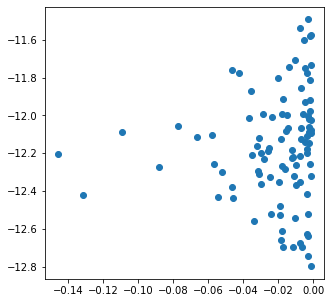




Generation: 3

N pep:  438
Best peptide: -13.585
N pep under -13 kcal/mol: 020
N pep under -12 kcal/mol: 169
N pep under -11 kcal/mol: 206
N pep under -10 kcal/mol: 212
N pep under -9 kcal/mol: 222
N pep under -8 kcal/mol: 251
N pep under -7 kcal/mol: 320
N pep under -6 kcal/mol: 381
N pep under -5 kcal/mol: 438
Non binding pep        : 000


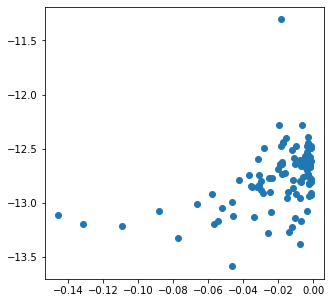

In [183]:
custom_candidate_fps5 = []
custom_candidate_y5 = []

NGEN = 3
NIND = 250
NCAN = 96
SIGMA = 0.2

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    # Convert to HELM string
    connections = []
    candidates = [build_helm_string({'PEPTIDE1': p}, connections) for p in list(random_peptides)]
    candidate_scores = list(random_peptide_scores)
    
    print('\n\n')
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-13, -12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))

        # Fit GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)
        
        # Find new candidates (local GA optimization)
        #acq = AcqScoring(model, probability_of_improvement, y_exp, sequence_type='helm')
        acq = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm')
        lgao = LocalGAOptimization(acq, monomer_aa1_lib, probability_matrix, NGEN, NIND, SIGMA, greater_is_better=False)
        lgao.run(candidates, candidate_scores)
        
        # Take NCAN (96) best candidates found
        candidate_sequences = lgao.candidates[:NCAN]
        
        # Get affinitiy binding values (MAKE TEST)
        candidate_sequences_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidate_sequences]
        y_candidates = np.array(predict_peptide_affinity_binding(candidate_sequences_fasta, pssm, reg))
        
        # Add candidates to the training set
        candidates.extend(candidate_sequences)
        candidate_scores.extend(list(y_candidates))
        candidate_fps = map4_fingerprint(candidate_sequences, input_type='helm')

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, torch.from_numpy(y_candidates)])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-13, -12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates)
        plt.show()
        print('\n\n')
    
    custom_candidate_fps5.append(X_fps_exp.detach().numpy())
    custom_candidate_y5.append(y_exp.detach().numpy())

custom_candidate_fps5 = np.array(custom_candidate_fps5)
custom_candidate_y5 = np.array(custom_candidate_y5)


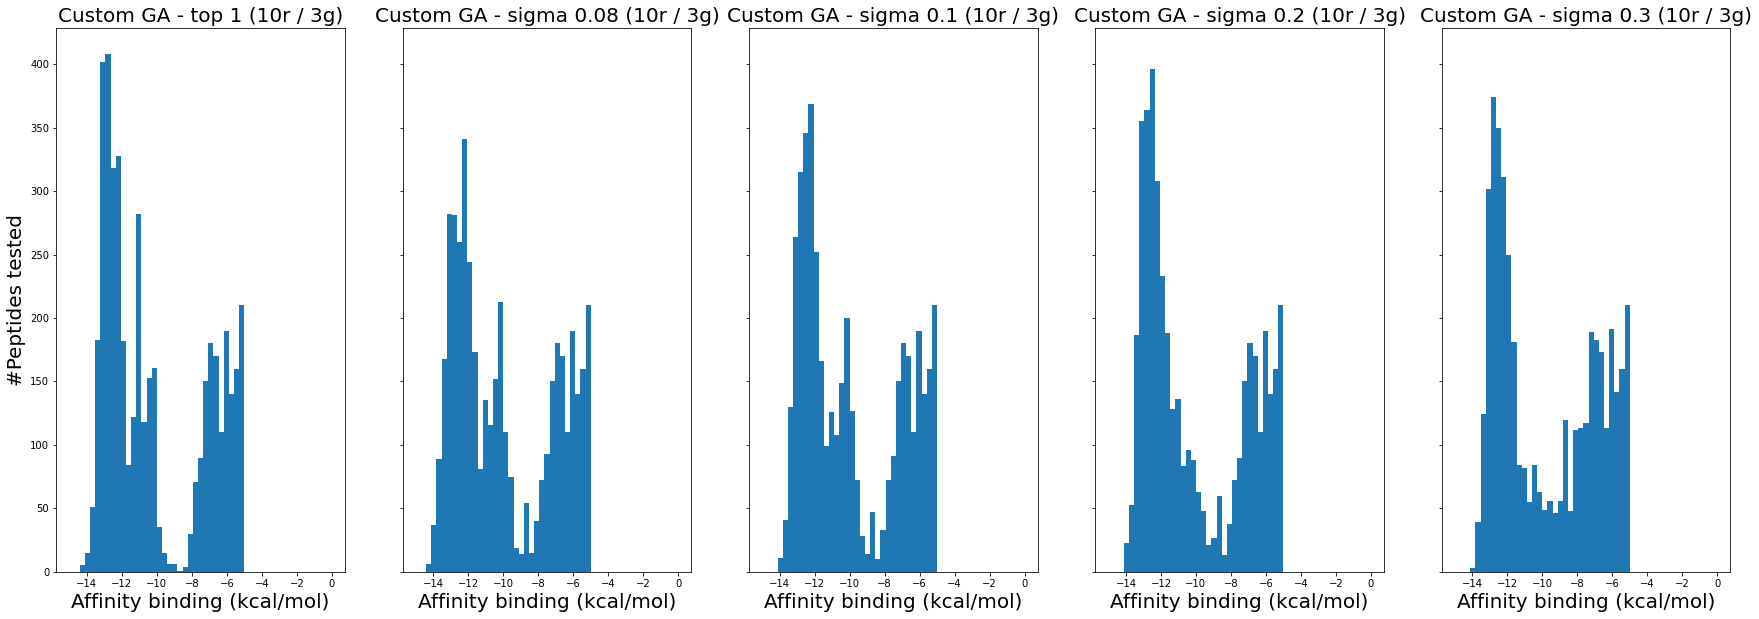

In [186]:
fig, axarr = plt.subplots(1, 5, figsize=(30, 10), sharey=True)
axarr[0].hist(custom_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[1].hist(custom_candidate_y4.flatten(), bins=np.linspace(-15, 0, 52))
axarr[2].hist(custom_candidate_y3.flatten(), bins=np.linspace(-15, 0, 52))
axarr[3].hist(custom_candidate_y2.flatten(), bins=np.linspace(-15, 0, 52))
axarr[4].hist(custom_candidate_y5.flatten(), bins=np.linspace(-15, 0, 52))

axarr[0].set_title('Custom GA - top 1 (10r / 3g)', fontsize=20)
axarr[1].set_title('Custom GA - sigma 0.08 (10r / 3g)', fontsize=20)
axarr[2].set_title('Custom GA - sigma 0.1 (10r / 3g)', fontsize=20)
axarr[3].set_title('Custom GA - sigma 0.2 (10r / 3g)', fontsize=20)
axarr[4].set_title('Custom GA - sigma 0.3 (10r / 3g)', fontsize=20)

axarr[0].set_ylabel('#Peptides tested', fontsize=20)
axarr[0].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[1].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[2].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[3].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[4].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)

plt.savefig('figure_baye_opt_comparison_custom_GA_top1_vs_sigmas_sampling6.png', dpi=300, bbox_inches='tight')
plt.show()